In [1]:
import openturns as ot
import matplotlib.pyplot as plt
import numpy as np
import math
ot.RandomGenerator.SetSeed(42)

# ======================================== Fonction de plot ========================================
def plot_field(field, mode="plot", ax=None, title=None, vmin=None, vmax=None, add_colorbar=True):
    mesh = field.getMesh()

    x = mesh.getVertices().getMarginal(0)
    y = mesh.getVertices().getMarginal(1)
    z = field.getValues()

    x_unique = np.unique(x)
    y_unique = np.unique(y)
    nx = len(x_unique)
    ny = len(y_unique)

    X = np.array(x).reshape(ny, nx)
    Y = np.array(y).reshape(ny, nx)
    Z = np.array(z).reshape(ny, nx)

    if mode == "plot":
        fig, ax_local = plt.subplots(figsize=(6, 4))
    elif mode == "subplot":
        if ax is None:
            raise ValueError("En mode 'subplot', fournir un axe via le paramètre ax.")
        fig, ax_local = ax.figure, ax
    else:
        raise ValueError("mode doit être 'plot' ou 'subplot'.")

    contour = ax_local.contourf(X, Y, Z, levels=15, vmin=vmin, vmax=vmax)
    if add_colorbar:
        fig.colorbar(contour, ax=ax_local)
    if title:
        ax_local.set_title(title)

    return fig, ax_local, contour


# ======================== Maillage & Transformation par sigmoïde ========================
mesher = ot.IntervalMesher([50, 50])
mesh = mesher.build(ot.Interval([0.0, 0.0], [2.0, 2.0]))
sigmoid = ot.SymbolicFunction(['z'], ['1/(1+exp(-z))'])
field_function = ot.PythonFieldFunction(mesh, 1, mesh, 1, sigmoid)


### Tests de différents hyperparamètres

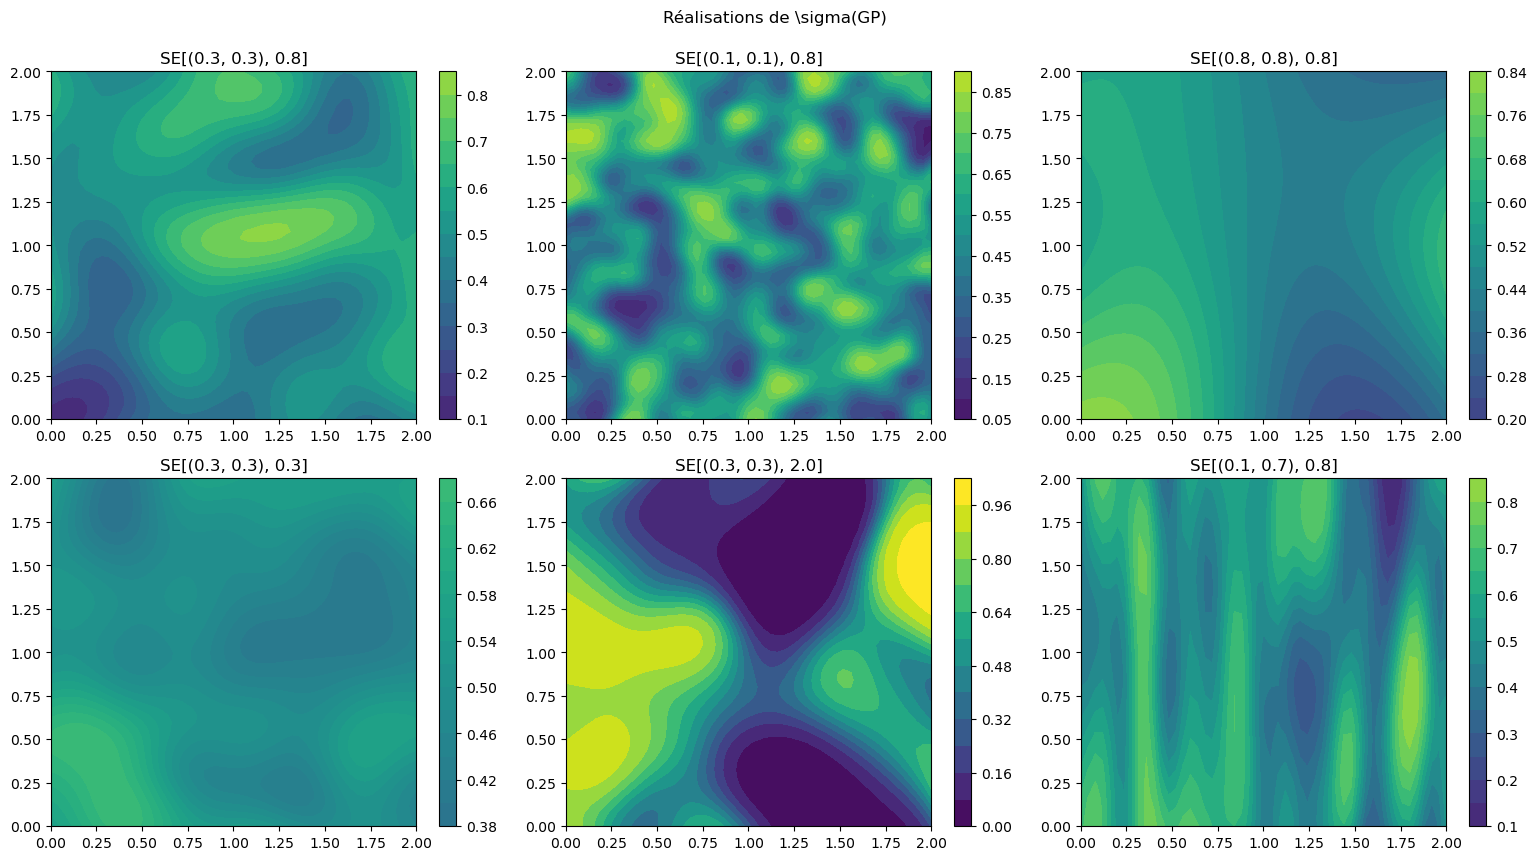

In [2]:
# Grille d'hyperparamètres du noyau SE : ([lx, ly], amplitude)
param_grid = [
    ([0.3, 0.3], 0.8),    # référence (subjectif)
    ([0.1, 0.1], 0.8),    # plus rugeux
    ([0.8, 0.8], 0.8),    # plus lisse
    ([0.3, 0.3], 0.3),    # amplitude plus faible
    ([0.3, 0.3], 2.0),    # amplitude plus forte
    ([0.1, 0.7], 0.8),    # anisotrope
]

fields = []
for scales, amp in param_grid:
    cov = ot.SquaredExponential(scales, [amp])
    gp = ot.GaussianProcess(cov, mesh)
    process = ot.CompositeProcess(field_function, gp)
    fields.append((process.getRealization(), scales, amp))

# Bornes de couleurs communes pour comparaison cohérente
all_vals = np.concatenate([np.array(f[0].getValues()).ravel() for f in fields])
zmin, zmax = float(np.min(all_vals)), float(np.max(all_vals))

# Grille de subplots
n = len(fields)
ncols = min(3, n)
nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(5.2*ncols, 4.3*nrows), squeeze=False)
axes_flat = axes.ravel()

for i, (field_f, scales, amp) in enumerate(fields):
    fig, ax_i, _ = plot_field(
        field_f,
        mode="subplot",
        ax=axes_flat[i],
        title=f"SE[({scales[0]}, {scales[1]}), {amp}]",
        vmin=zmin, vmax=zmax,
        add_colorbar=True
    )

# Masquer axes inutilisés
for ax in axes_flat[n:]:
    ax.axis('off')

fig.suptitle(r"Réalisations de \sigma(GP)", y=0.995)
plt.tight_layout()
plt.show()


(<Figure size 600x400 with 2 Axes>,
 <Axes: >,
 <matplotlib.contour.QuadContourSet at 0x17ffdeab0>)

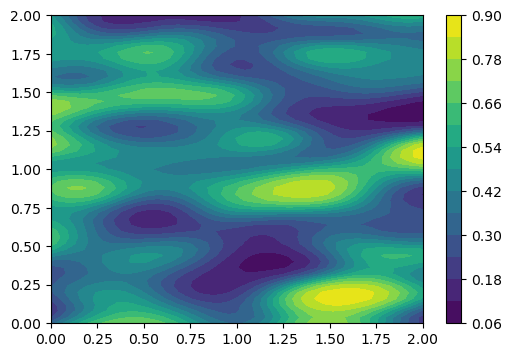

In [3]:
# Create mesh 
mesher = ot.IntervalMesher([50, 50]) 
mesh = mesher.build(ot.Interval([0.0, 0.0], [2.0, 2.0])) 

cov = ot.SquaredExponential([0.35, 0.12], [1.0]) 
X = ot.GaussianProcess(cov, mesh)

sigmoid = ot.SymbolicFunction(['z'], ['1/(1+exp(-z))']) 
field_function = ot.PythonFieldFunction(mesh, 1, mesh, 1, sigmoid) 
process = ot.CompositeProcess(field_function, X) 

# Plot a realization of the composite process 
field_f = process.getRealization() 
plot_field(field_f)

### Ajout d'une moyenne dans le GP

(<Figure size 600x400 with 2 Axes>,
 <Axes: >,
 <matplotlib.contour.QuadContourSet at 0x31a15b0b0>)

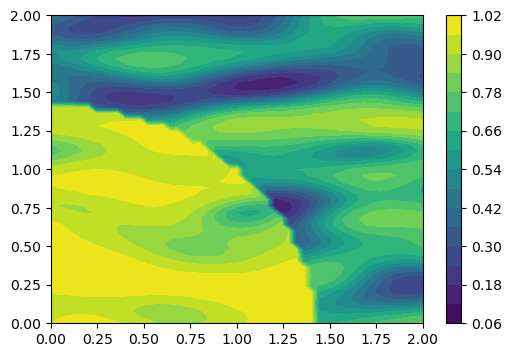

In [4]:
# Create mesh
mesher = ot.IntervalMesher([50, 50])
mesh = mesher.build(ot.Interval([0.0, 0.0], [2.0, 2.0]))

def tend(X):
    return [3*(X[0]**2 + X[1]**2 <= 2.0)]

f = ot.PythonFunction(2, 1, tend)
fTrend = ot.TrendTransform(f, mesh)

cov = ot.SquaredExponential([0.35, 0.12], [1.0])
X = ot.GaussianProcess(fTrend ,cov, mesh)

sigmoid = ot.SymbolicFunction(['z'], ['1/(1+exp(-z))'])
field_function = ot.PythonFieldFunction(mesh, 1, mesh, 1, sigmoid)
process = ot.CompositeProcess(field_function, X)

# Plot a realization of the composite process
field_f = process.getRealization()
plot_field(field_f)

### Ajout du zonage dans la moyenne 

Aiire du polygone P1 : 0.0741
Aiire du polygone P2 : 0.2855
Aiire du polygone P3 : 0.1362
Aiire du polygone P4 : 0.7064
Aiire du polygone P5 : 0.4178
Aiire du polygone P6 : 0.2462
Aiire du polygone P7 : 0.2520
Aiire du polygone P8 : 0.1560
Aiire du polygone P9 : 0.3490


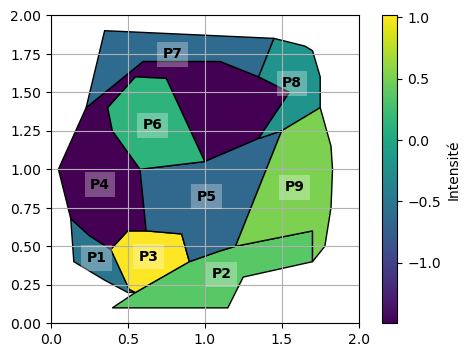

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon
from matplotlib.colors import Normalize

# Polygones dans [0,2]²
polygons = [
    Polygon([(0.5,0.2), (0.55,0.2), (0.51,0.22), (0.39,0.48), (0.25,0.57), (0.13,0.68), (0.15,0.4), (0.35,0.28)]),
    Polygon([(0.4,0.1), (1.15,0.1), (1.25,0.3), (1.7,0.4), (1.7,0.6), (1.2,0.5), (1.1,0.47), (0.9,0.4), (0.55,0.2)]),
    Polygon([(0.55,0.2), (0.9,0.4), (0.85,0.58), (0.62,0.6), (0.5,0.6), (0.39,0.48), (0.51,0.22), (0.55,0.2)]),
    Polygon([(0.13,0.68), (0.25,0.57), (0.39,0.48), (0.5,0.6), (0.62,0.6), (0.58,1.0), (0.4,1.25), (0.37,1.4), (0.55,1.6), 
             (0.75,1.59), (1.0,1.05), (1.35,1.2), (1.55,1.5), (1.35,1.6), (1.1, 1.7), (0.6,1.7), (0.23,1.4), (0.05,1.0)]),
    Polygon([(0.62,0.6), (0.85,0.58), (0.9,0.4), (1.1,0.47), (1.2,0.5), (1.5,1.25), (1.35,1.2), (1.0,1.05), (0.58,1.0)]),
    Polygon([(0.58,1.0), (1.0,1.05), (0.75,1.59), (0.55,1.6), (0.37,1.4), (0.4,1.25)]),
    Polygon([(0.23,1.4), (0.35,1.9), (1.45,1.85), (1.35,1.6), (1.1, 1.7), (0.6,1.7), (0.23,1.4)]),
    Polygon([(1.45,1.85), (1.35,1.6), (1.55,1.5), (1.35,1.2), (1.5,1.25), (1.75,1.4), (1.75,1.6), (1.7,1.77), (1.65,1.80)]),
    Polygon([(1.5,1.25), (1.2,0.5), (1.7,0.6), (1.7,0.4), (1.78,0.5), (1.82,0.75), (1.83,1.0), (1.82,1.15), (1.75,1.4)])
]

# Intensités (poids de zone)
#zone_weights = np.array([0.05, 0.05, 0.25, 0.01, 0.1, 0.14, 0.14, 0.01, 0.25]) 
zone_weights = np.random.normal(loc=0.0, scale=1.0, size=9)
cmap = plt.cm.viridis
norm = Normalize(vmin=zone_weights.min(), vmax=zone_weights.max())

# Calcul des aires
areas = np.array([poly.area for poly in polygons])
for i, area in enumerate(areas, 1):
    print(f"Aiire du polygone P{i} : {area:.4f}")


# =========================================== Affichage ===========================================
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_xlim(0, 2)
ax.set_ylim(0, 2)
ax.set_aspect('equal')

for i, (poly, intensity) in enumerate(zip(polygons, zone_weights), start=1):
    color = cmap(norm(intensity))
    patch = plt.Polygon(list(poly.exterior.coords), facecolor=color, edgecolor='black')
    ax.add_patch(patch)

    # Position du label
    if i == 4:
        label_x, label_y = 0.32, 0.9  # Coordonnées choisies manuellement pour P4
    else:
        centroid = poly.centroid
        label_x, label_y = centroid.x, centroid.y

    ax.text(label_x, label_y, f'P{i}', color='black', weight='bold',
            ha='center', va='center', fontsize=10,
            bbox=dict(facecolor='white', alpha=0.3, edgecolor='none'))

# Colorbar et finalisation
plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), ax=ax, label="Intensité")
#plt.title("\nZonage sismotectonique - Cas jouet\n")
plt.grid(True)
plt.show()
#fig.savefig("figure_zonage_cas_jouet.png") 



(<Figure size 600x400 with 2 Axes>,
 <Axes: >,
 <matplotlib.contour.QuadContourSet at 0x31a124ce0>)

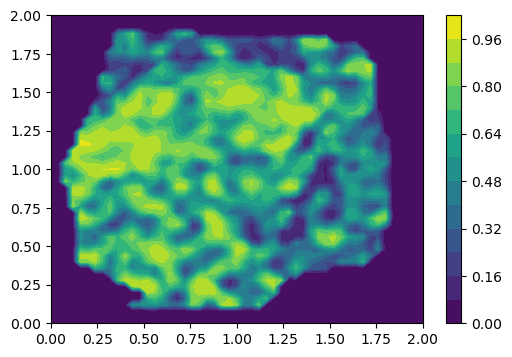

In [6]:
import openturns as ot
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon, Point
from shapely.prepared import prep

polygons = [
    Polygon([(0.5,0.2), (0.55,0.2), (0.51,0.22), (0.39,0.48), (0.25,0.57), (0.13,0.68), (0.15,0.4), (0.35,0.28)]),
    Polygon([(0.4,0.1), (1.15,0.1), (1.25,0.3), (1.7,0.4), (1.7,0.6), (1.2,0.5), (1.1,0.47), (0.9,0.4), (0.55,0.2)]),
    Polygon([(0.55,0.2), (0.9,0.4), (0.85,0.58), (0.62,0.6), (0.5,0.6), (0.39,0.48), (0.51,0.22), (0.55,0.2)]),
    Polygon([(0.13,0.68), (0.25,0.57), (0.39,0.48), (0.5,0.6), (0.62,0.6), (0.58,1.0), (0.4,1.25), (0.37,1.4), (0.55,1.6), 
             (0.75,1.59), (1.0,1.05), (1.35,1.2), (1.55,1.5), (1.35,1.6), (1.1, 1.7), (0.6,1.7), (0.23,1.4), (0.05,1.0)]),
    Polygon([(0.62,0.6), (0.85,0.58), (0.9,0.4), (1.1,0.47), (1.2,0.5), (1.5,1.25), (1.35,1.2), (1.0,1.05), (0.58,1.0)]),
    Polygon([(0.58,1.0), (1.0,1.05), (0.75,1.59), (0.55,1.6), (0.37,1.4), (0.4,1.25)]),
    Polygon([(0.23,1.4), (0.35,1.9), (1.45,1.85), (1.35,1.6), (1.1, 1.7), (0.6,1.7), (0.23,1.4)]),
    Polygon([(1.45,1.85), (1.35,1.6), (1.55,1.5), (1.35,1.2), (1.5,1.25), (1.75,1.4), (1.75,1.6), (1.7,1.77), (1.65,1.80)]),
    Polygon([(1.5,1.25), (1.2,0.5), (1.7,0.6), (1.7,0.4), (1.78,0.5), (1.82,0.75), (1.83,1.0), (1.82,1.15), (1.75,1.4)])
]
#zone_weights = np.array([0.05, 0.05, 0.25, 0.01, 0.1, 0.14, 0.14, 0.01, 0.25]) 
zone_weights = np.random.normal(loc=0.0, scale=1.0, size=9)

Zones = [(prep(p), float(w)) for p, w in zip(polygons, zone_weights)]

mesher = ot.IntervalMesher([50, 50])
mesh = mesher.build(ot.Interval([0.0, 0.0], [2.0, 2.0]))

def tend(X):
    x, y = float(X[0]), float(X[1])
    pt = Point(x, y)
    for P, w in Zones:
        if P.covers(pt):
            #return [-np.log( (max(abs(zone_weights)) /abs(w))-1 )]  
            return [w]           
    return [-np.inf]

f = ot.PythonFunction(2, 1, tend)
fTrend = ot.TrendTransform(f, mesh)
cov = ot.SquaredExponential([0.05, 0.05], [1.0])
X = ot.GaussianProcess(fTrend, cov, mesh)

sigmoid = ot.SymbolicFunction(['z'], ['1/(1+exp(-z))'])
field_function = ot.PythonFieldFunction(mesh, 1, mesh, 1, sigmoid)
process = ot.CompositeProcess(field_function, X)

field_f = process.getRealization()
plot_field(field_f)
#fig.savefig("figure_gp_zonage.png") 


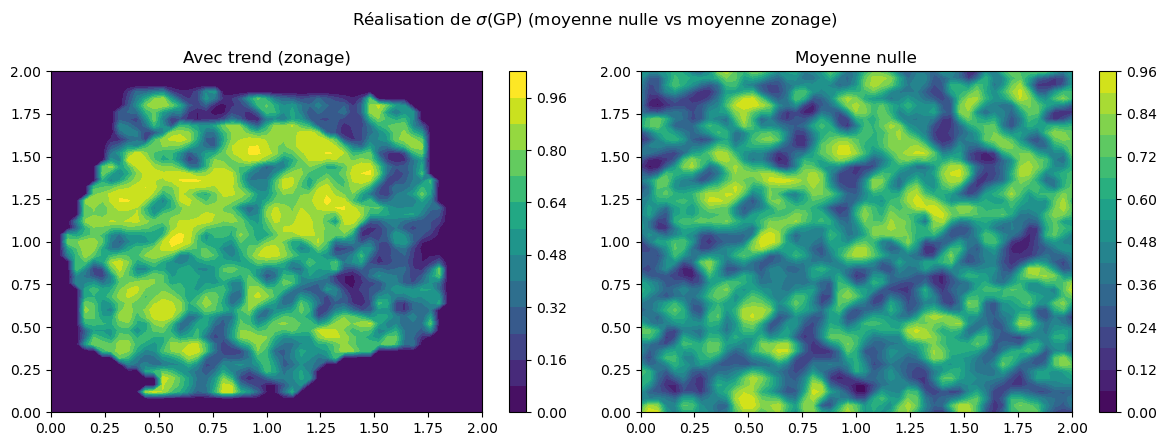

In [7]:
# Avec trend (zonage)
X_trend = ot.GaussianProcess(fTrend, cov, mesh)
process_trend = ot.CompositeProcess(field_function, X_trend)

# Moyenne nulle
X_zero = ot.GaussianProcess(cov, mesh)
process_zero = ot.CompositeProcess(field_function, X_zero)

# Noyau fixe pour comparaison 
seed = 123
ot.RandomGenerator.SetSeed(seed)
field_trend = process_trend.getRealization()
ot.RandomGenerator.SetSeed(seed)
field_zero  = process_zero.getRealization()


fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))
vmin, vmax = 0.0, 1.0

plot_field(field_trend, mode="subplot", ax=axes[0],
           title="Avec trend (zonage)", vmin=vmin, vmax=vmax, add_colorbar=True)

plot_field(field_zero,  mode="subplot", ax=axes[1],
           title="Moyenne nulle", vmin=vmin, vmax=vmax, add_colorbar=True)

fig.suptitle(r"Réalisation de $\sigma$(GP) (moyenne nulle vs moyenne zonage)")
plt.tight_layout()
plt.show()


# Gibbs sampler pour SGCP

In [ ]:
import numpy as np
from shapely.geometry import Point
from polyagamma import random_polyagamma
import openturns as ot
from shapely.geometry import Point as ShapelyPoint
import matplotlib.pyplot as plt


class SGCP_GibbsSampler:
    """
    
    """

    def __init__(
        self,
        X_bounds,
        Y_bounds,
        T,
        Areas,
        nu,
        a_mu,
        b_mu,
        jitter=1e-5,
        rng_seed=None,
    ):
        self.X_bounds = tuple(X_bounds)
        self.Y_bounds = tuple(Y_bounds)
        self.T = T
        self.Areas = Areas
        self.nu = ot.Point(nu)
        self.a_mu = a_mu
        self.b_mu = b_mu
        self.jitter = jitter

        if rng_seed is not None:
            ot.RandomGenerator.SetSeed(rng_seed)
            self.rng_state = ot.RandomGenerator.GetState()

        self.areas = [a[0] for a in self.Areas]
        self.epsilons = [a[1] for a in self.Areas]
        self.J = len(self.areas)


    # ==========================================================================
    # ------------------------------- Outillage --------------------------------
    # ==========================================================================

    @staticmethod
    def sigma(z):
        """
        
        """
        z_array = np.array(z)
        return ot.Point(1.0 / (1.0 + np.exp(-z_array)))

    def compute_kernel(self, XY_data, XY_new=None):
        """
        
        """
        nu0, nu1, nu2 = map(float, self.nu)

        if not isinstance(XY_data, ot.Sample):
            XY_data = ot.Sample(np.asarray(XY_data, dtype=float).tolist())
        N_data = XY_data.getSize()

        kernel = ot.SquaredExponential([nu1, nu2], [nu0])

        if XY_new is None:
            K = kernel.discretize(XY_data)
            return ot.CovarianceMatrix(np.array(K, dtype=float).tolist())

        if not isinstance(XY_new, ot.Sample):
            XY_new = ot.Sample(np.asarray(XY_new, dtype=float).tolist())
        N_new = XY_new.getSize()

        XY_all = ot.Sample(N_data + N_new, 2)
        for i in range(N_data):
            XY_all[i, 0] = XY_data[i, 0]
            XY_all[i, 1] = XY_data[i, 1]
        for i in range(N_new):
            XY_all[N_data + i, 0] = XY_new[i, 0]
            XY_all[N_data + i, 1] = XY_new[i, 1]
        K_all = kernel.discretize(XY_all)

        K_dd = ot.CovarianceMatrix(N_data)
        for i in range(N_data):
            for j in range(i, N_data):
                K_dd[i, j] = K_all[i, j]

        K_new_data = ot.Matrix(N_new, N_data)
        for i in range(N_new):
            for j in range(N_data):
                K_new_data[i, j] = K_all[N_data + i, j]

        K_new_new = ot.CovarianceMatrix(N_new)
        for i in range(N_new):
            for j in range(i, N_new):
                K_new_new[i, j] = K_all[N_data + i, N_data + j]

        return K_dd, K_new_data, K_new_new

    def compute_U_from_areas(self, D_xy):
        """
        
        """
        if not isinstance(D_xy, ot.Sample):
            D_xy_sample = ot.Sample(np.asarray(D_xy, dtype=float).tolist())
        else:
            D_xy_sample = D_xy

        n = D_xy_sample.getSize()
        U = ot.Sample(n, self.J)

        for k in range(n):
            pt = D_xy_sample[k]
            pt_shapely = ShapelyPoint(pt[0], pt[1])

            for j, P in enumerate(self.areas):
                if P.covers(pt_shapely):
                    U[k, j] = 1.0
                    break

        return ot.Matrix(U)

    def sample_candidats(self, N):
        """
        
        """
        xmin, xmax = self.X_bounds
        ymin, ymax = self.Y_bounds

        marginal_x = ot.Uniform(xmin, xmax)
        marginal_y = ot.Uniform(ymin, ymax)
        distribution = ot.ComposedDistribution([marginal_x, marginal_y])
        sample = distribution.getSample(int(N))

        return sample


    # =================================================================================
    # -------------------------- Posteriors conditionnelles ---------------------------
    # =================================================================================

    def update_mu_tilde(self, Z, Pi_S):
        """
        
        """
        xmin, xmax = self.X_bounds
        ymin, ymax = self.Y_bounds

        N_0 = sum(1 for z in Z if z == 0.0)
        N_Pi = Pi_S.getSize()

        shape = self.a_mu + N_0 + N_Pi
        rate = self.b_mu + self.T * (xmax - xmin) * (ymax - ymin)

        mu_tilde = ot.Gamma(shape, rate, 0.0).getRealization()[0]

        return float(mu_tilde)

    def update_epsilons(self, f_Df, K_ff, U):
        """
        
        """
        n = K_ff.getDimension()

        K_cov_reg = ot.CovarianceMatrix(K_ff)
        for i in range(n):
            K_cov_reg[i, i] += float(self.jitter)
        K_inv = K_cov_reg.inverse()

        U_mat = ot.Matrix(U)
        U_T = U_mat.transpose()

        A_mat = U_T * K_inv * U_mat + ot.IdentityMatrix(self.J)
        A_array = np.array(A_mat)
        A_array = 0.5 * (A_array + A_array.T)
        A_array += float(self.jitter) * np.eye(self.J)
        A_cov = ot.CovarianceMatrix(A_array.tolist())
        Sigma_sym = A_cov.inverse()
        Sigma = ot.CovarianceMatrix(np.array(Sigma_sym).tolist())

        B = U_T * (K_inv * f_Df)
        mu = Sigma * B

        epsilons = ot.Normal(mu, Sigma).getRealization()

        return epsilons

    def update_f(self, x, y, eps, Z, omega_D0, Pi_S):
        """
        
        """
        idx = [i for i in range(len(Z)) if Z[i] == 0.0]
        N_0 = len(idx)

        if N_0 == 0:
            raise ValueError("N_0 = 0 ; Pas possible pour SGCP")

        # 1) D_0 -> (x,y) + omega_D_0
        D_0 = ot.Sample(N_0, 2)
        omega_D_0 = ot.Point(N_0)
        for k, i in enumerate(idx):
            D_0[k, 0] = x[i]
            D_0[k, 1] = y[i]
            omega_D_0[k] = omega_D0[i]

        # 2) Pi_S -> PiS(x,y) + omega_Pi
        N_Pi = Pi_S.getSize()
        if N_Pi > 0:
            PiS = ot.Sample(N_Pi, 2)
            omega_Pi = ot.Point(N_Pi)
            for i in range(N_Pi):
                PiS[i, 0] = Pi_S[i, 0]
                PiS[i, 1] = Pi_S[i, 1]
                omega_Pi[i] = Pi_S[i, 2]
        else:
            PiS = ot.Sample(0, 2)
            omega_Pi = ot.Point(0)

        # 3) D_f = D_0 U Pi_S
        N_f = N_0 + N_Pi
        D_f = ot.Sample(N_f, 2)
        for i in range(N_0):
            D_f[i, 0] = D_0[i, 0]
            D_f[i, 1] = D_0[i, 1]
        for i in range(N_Pi):
            D_f[N_0 + i, 0] = PiS[i, 0]
            D_f[N_0 + i, 1] = PiS[i, 1]

        # 4) U et m_f = U * eps
        U = self.compute_U_from_areas(D_f)
        eps_mat = ot.Matrix([[float(eps[j])] for j in range(self.J)])
        m_f_mat = U * eps_mat
        m_f = ot.Point([float(m_f_mat[i, 0]) for i in range(N_f)])

        # 5) K_ff
        K_ff = self.compute_kernel(D_f)
        for i in range(N_f):
            K_ff[i, i] += float(self.jitter)
        K_inv = K_ff.inverse()

        # 6) Omega
        omega_diag = ot.Point(N_f)
        for i in range(N_0):
            omega_diag[i] = omega_D_0[i]
        for i in range(N_Pi):
            omega_diag[N_0 + i] = omega_Pi[i]

        Omega = ot.CovarianceMatrix(N_f)
        for i in range(N_f):
            Omega[i, i] = omega_diag[i]

        # 7) u = [0.5,...,0.5, -0.5,...,-0.5]
        u = ot.Point(N_f)
        for i in range(N_0):
            u[i] = 0.5
        for i in range(N_Pi):
            u[N_0 + i] = -0.5

        # 8) Sigma_f et mu_f
        A_mat = Omega + K_inv
        A_array = np.array(A_mat)
        A_array = 0.5 * (A_array + A_array.T)
        A_array += float(self.jitter) * np.eye(N_f)
        A = ot.CovarianceMatrix(A_array.tolist())
        Sigma_f_sym = A.inverse()
        Sigma_f = ot.CovarianceMatrix(np.array(Sigma_f_sym).tolist())

        temp = K_inv * m_f + u
        mu_f = Sigma_f * temp

        f_new = ot.Normal(mu_f, Sigma_f).getRealization()

        return f_new, D_f, U, K_ff, m_f

    def sample_Pi_S(self, mu_tilde, X_data, Y_data, f_data, eps):
        """
        
        """
        N = X_data.getSize()
        xmin, xmax = self.X_bounds
        ymin, ymax = self.Y_bounds
        area = (xmax - xmin) * (ymax - ymin)

        # 1) Candidats et données observées
        mean_cand = float(mu_tilde * self.T * area)
        N_cand = int(ot.Poisson(mean_cand).getRealization()[0])
        if N_cand == 0:
            return ot.Sample(0, 3)

        XY_cand = self.sample_candidats(N_cand)
        XY_data = ot.Sample([[X_data[i], Y_data[i]] for i in range(N)])

        # 2) GP conditionnel
        U_data_mat = self.compute_U_from_areas(XY_data)
        U_cand_mat = self.compute_U_from_areas(XY_cand)
        eps_col = ot.Matrix([[float(eps[j])] for j in range(self.J)])
        m_data_mat = U_data_mat * eps_col
        m_cand_mat = U_cand_mat * eps_col
        m_data = ot.Point([float(m_data_mat[i, 0]) for i in range(N)])
        m_cand = ot.Point([float(m_cand_mat[i, 0]) for i in range(N_cand)])

        K_dd, K_star_d, K_star_star = self.compute_kernel(XY_data, XY_cand)
        K_dd_reg = ot.CovarianceMatrix(K_dd)
        for i in range(N):
            K_dd_reg[i, i] += float(self.jitter)
        K_inv = K_dd_reg.inverse()

        delta = f_data - m_data
        mu_star = m_cand + K_star_d * (K_inv * delta)

        Sigma_star_mat = K_star_star - K_star_d * (K_inv * K_star_d.transpose())
        Sigma_array = np.array(Sigma_star_mat)
        Sigma_array = 0.5 * (Sigma_array + Sigma_array.T)
        Sigma_array += float(self.jitter) * np.eye(N_cand)
        Sigma_star = ot.CovarianceMatrix(Sigma_array.tolist())

        f_star = ot.Normal(mu_star, Sigma_star).getRealization()

        # 3) Phase de Thinning
        accept_probs = self.sigma(-f_star)
        Uu = ot.Uniform(0.0, 1.0).getSample(N_cand)
        mask = [i for i in range(N_cand) if Uu[i, 0] < accept_probs[i]]
        if len(mask) == 0:
            return ot.Sample(0, 3)

        XY_acc = ot.Sample(len(mask), 2)
        f_acc = np.zeros(len(mask))
        for k, i in enumerate(mask):
            XY_acc[k, 0] = XY_cand[i, 0]
            XY_acc[k, 1] = XY_cand[i, 1]
            f_acc[k] = f_star[i]

        # 4) Construction de Pi_S
        omega_acc = random_polyagamma(1.0, f_acc)
        n_acc = len(omega_acc)
        Pi_S = ot.Sample(n_acc, 3)
        for i in range(n_acc):
            Pi_S[i, 0] = XY_acc[i, 0]
            Pi_S[i, 1] = XY_acc[i, 1]
            Pi_S[i, 2] = omega_acc[i]

        return Pi_S


    # =====================================================================================
    # ----------------------------------- Run du Gibbs ------------------------------------
    # =====================================================================================

    def run(self, t, x, y, eps_init, mu_init, n_iter=1000, verbose=True, verbose_every=100):
        """
        
        """
        N = len(t)

        # Seulement évènements de fond : ETAS = 0
        Z = ot.Point([0.0] * N)

        # Initialisations
        eps = ot.Point(eps_init)
        mu_tilde = float(mu_init)
        XY_data = ot.Sample([[x[i], y[i]] for i in range(N)])
        U_data = self.compute_U_from_areas(XY_data)
        f_data = ot.Point(U_data * eps)

        # Stockage
        mu_chain = np.zeros(n_iter)
        eps_chain = np.zeros((n_iter, self.J))
        nPi_chain = np.zeros(n_iter, dtype=int)
        fdata_chain = np.zeros((n_iter, N))

        if verbose:
            print("=" * 100)
            print(
                "-" * 29
                + f" Démarrage Gibbs: {n_iter} itérations, N={N} "
                + "-" * 29
            )
            print("=" * 100 + "\n")

        for it in range(n_iter):
            try:
                # 1) omega_D0 | ...
                omega_D0 = ot.Point(random_polyagamma(1.0, f_data))

                # 2) Pi_S | ...
                Pi_S = self.sample_Pi_S(mu_tilde, x, y, f_data, eps)

                # 3) f_Df | ...
                f_Df, D_f_xy, U_Df, K_ff, m_f = self.update_f(
                    x, y, eps, Z, omega_D0, Pi_S
                )
                f_data = ot.Point([f_Df[i] for i in range(N)])

                # 4) eps | ...
                eps = self.update_epsilons(f_Df, K_ff, U_Df)

                # 5) mu_tilde | ...
                mu_tilde = self.update_mu_tilde(Z, Pi_S)

                # Affichage
                if verbose and (it % verbose_every == 0 or it == n_iter - 1):
                    eps_arr = np.array(eps)
                    n_pi = Pi_S.getSize()
                    print(
                        f"[Gibbs iteration {it}] "
                        f"mu_tilde = {mu_tilde:.4f} | "
                        f"|Pi| = {n_pi} | "
                        f"eps = {eps_arr} "
                    )

                # Stockage
                mu_chain[it] = mu_tilde
                eps_chain[it, :] = np.array(eps)
                nPi_chain[it] = Pi_S.getSize()
                fdata_chain[it, :] = np.array(f_data)

            except Exception as e:
                print(f"\nErreur iteration {it} : {e}")
                raise

        if verbose:
            print("\n" + "=" * 100)
            print("-" * 41 + " Gibbs terminé !! " + "-" * 41)
            print("=" * 100)

        return {
            "mu_tilde": mu_chain,
            "eps": eps_chain,
            "nPi": nPi_chain,
            "f_data": fdata_chain,
            "last_state": {
                "mu_tilde": mu_tilde,
                "eps": np.array(eps),
                "nu": list(self.nu),
            },
        }


    # =====================================================================================
    # ---------------------------- Analyse postérieure ------------------------------------
    # =====================================================================================

    def posterior_summary(self, results, burn_in=0.3):
        """
        
        """
        mutilde_chain = np.asarray(results["mu_tilde"])
        eps_chain = np.asarray(results["eps"])
        f_chain = np.asarray(results["f_data"])
        burn = int(len(mutilde_chain) * burn_in)

        return {
            "mutilde_hat": float(mutilde_chain[burn:].mean()),
            "eps_hat": eps_chain[burn:].mean(axis=0),
            "f_data_hat": f_chain[burn:].mean(axis=0),
        }
    
    def posterior_gp(self, XY_data, f_data_hat, mesh, eps_hat):
        """
        
        """
        # Extraction des vertices du mesh
        XY_grid = mesh.getVertices()
        
        # Moyennes (U * eps)
        U_data = self.compute_U_from_areas(XY_data)
        U_grid = self.compute_U_from_areas(XY_grid)
        eps_col = ot.Matrix([[float(eps_hat[j])] for j in range(self.J)])
        m_data_mat = U_data * eps_col
        m_grid_mat = U_grid * eps_col
        m_data = ot.Point([float(m_data_mat[i, 0]) for i in range(U_data.getNbRows())])
        m_grid = ot.Point([float(m_grid_mat[i, 0]) for i in range(U_grid.getNbRows())])
        
        # Kernels
        N = XY_data.getSize()
        M = XY_grid.getSize()
        K_dd, K_gd, K_gg = self.compute_kernel(XY_data, XY_grid)
        
        K_dd_reg = ot.CovarianceMatrix(K_dd)
        for i in range(N):
            K_dd_reg[i, i] += float(self.jitter)    # Régularisation
        K_inv = K_dd_reg.inverse()

        # Moyenne postérieure : mu_post = m_grid + K_gd * K_dd^{-1} * (f_data - m_data)
        delta = f_data_hat - m_data
        mu_post = m_grid + K_gd * (K_inv * delta)

        # Covariance postérieure : Sigma_post = K_gg - K_gd * K_dd^{-1} * K_dg
        Sigma_post_mat = ot.Matrix(K_gg) - K_gd * (K_inv * K_gd.transpose())
        Sigma_post_np = np.array(Sigma_post_mat, dtype=float)
        Sigma_post_np = 0.5 * (Sigma_post_np + Sigma_post_np.T)   # Symétrisation, passage par numpy peut être pas nécessaire
        Sigma_post_np += float(self.jitter) * np.eye(M)     # Régularisation
        Sigma_post = ot.CovarianceMatrix(Sigma_post_np.tolist())
        
        return mu_post, Sigma_post

    def plot_posterior_intensity(
        self,
        x,
        y,
        t,
        results,
        nx=60,
        ny=60,
        burn_in=0.3
    ):
        """
        
        """
        post_sum = self.posterior_summary(results, burn_in)
        mutilde_hat = post_sum["mutilde_hat"]
        eps_hat = post_sum["eps_hat"]
        f_data_hat = post_sum["f_data_hat"]
        N = len(t)
        XY_data = ot.Sample([[x[i], y[i]] for i in range(N)])
        
        # Création du mesh 
        xmin, xmax = self.X_bounds
        ymin, ymax = self.Y_bounds
        interval = ot.Interval([xmin, ymin], [xmax, ymax])
        mesher = ot.IntervalMesher([nx - 1, ny - 1])      # nb d'arêtes
        mesh = mesher.build(interval)

        M = mesh.getVertices().getSize()
        if M > 10000:            # Critère pour éviter maillage trop grand (question de compléxité)
            raise ValueError(f"Maillage trop grand: {M} points.")

        mu_post_grid, Sigma_post_grid = self.posterior_gp(XY_data, f_data_hat, mesh, eps_hat)
        f_hat = mu_post_grid        # Estimateur de la moyenne a posteriori

        mu_hat = mutilde_hat * self.sigma(f_hat)         # Calcul de l'intensité estimée
        mu_sample = ot.Sample([[mu_hat[i]] for i in range(len(mu_hat))])
        mu_field = ot.Field(mesh, mu_sample)

        fig, axes = plt.subplots(1, 2, figsize=(13, 6))
        # Subplot 1 : Données
        ax = axes[0]
        sc = ax.scatter(
            x,
            y,
            c=t,
            s=18,
            alpha=0.7,
            edgecolors="black",
        )
        ax.set_title("Données observées (couleur = temps)")
        ax.set_xlim(self.X_bounds)
        ax.set_ylim(self.Y_bounds)
        ax.set_aspect("equal")
        ax.grid(alpha=0.3)
        plt.colorbar(sc, ax=ax).set_label("t")

        # Subplot 2 : Intensité avec plot_field
        ax = axes[1]
        plot_field(mu_field, mode="subplot", ax=ax, title=r"Intensité postérieure $\hat{\mu}(s)$", 
                   add_colorbar=True)
        ax.scatter(x, y, s=10, alpha=0.5, color="white", edgecolors="black", linewidths=0.5)
        ax.set_xlim(self.X_bounds)
        ax.set_ylim(self.Y_bounds)
        ax.grid(alpha=0.3, color="white", linewidth=0.5)

        # Titre global
        fig.suptitle(r"Analyse postérieure : $\hat{\mu}(s) = \hat{\tilde{\mu}} \cdot \sigma(\hat{f}(s))$", 
                     fontsize=13, fontweight="bold",)
        plt.tight_layout()
        plt.show()

        return {
            "mu_hat": mu_hat,
            "eps_hat": eps_hat,
            "f_data_hat": f_data_hat,
            "mu_post_grid": mu_post_grid,
            "Sigma_post_grid": Sigma_post_grid,
            "mu_field": mu_field,
            "mesh": mesh,
        }



### Données simulées

----- JEU DE DONNÉES SIMULÉES -----

Nombre d'événements : 114
Nombre de zones régulières : 4
Intensités : [1.5,3,5,0.5]
Premiers événements :
    [ v0        v1        v2        ]
0 : [ 0.651141  0.713882  6.2807    ]
1 : [ 0.741187  0.436493  0.267253  ]
2 : [ 0.211801  0.433739  8.38197   ]
3 : [ 0.693015  0.513509  0.763583  ]
4 : [ 0.0279034 0.566855  8.09314   ]


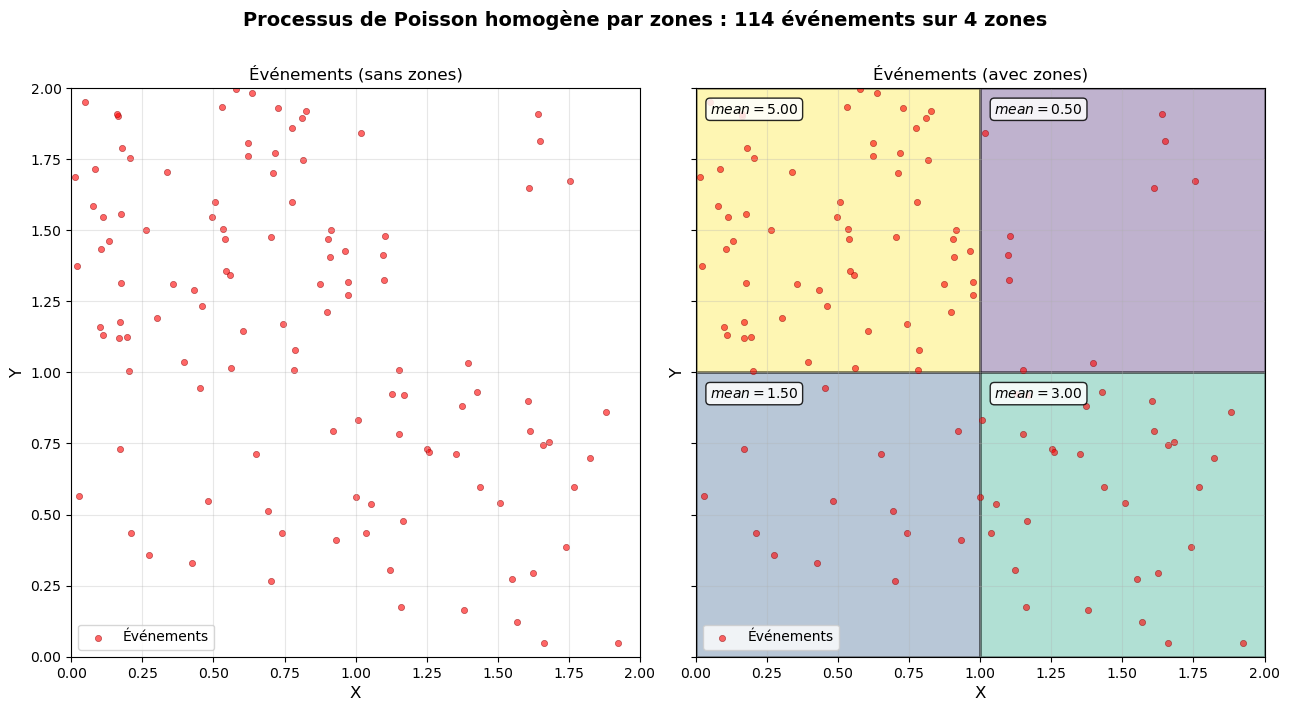

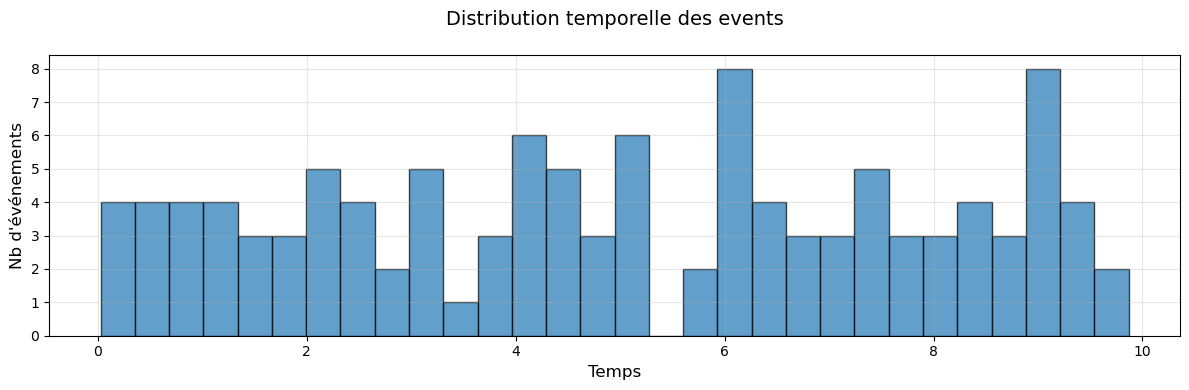

In [9]:
import numpy as np
import openturns as ot
from shapely.geometry import box
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle


def generate_data(
    X_bounds=(0.0, 2.0),
    Y_bounds=(0.0, 2.0),
    T=10.0,
    n_cols=3,
    n_rows=1,
    mus=6.0,
    rng_seed=0
):
    """
    
    """
    if rng_seed is not None:
        ot.RandomGenerator.SetSeed(rng_seed)
    
    xmin, xmax = X_bounds
    ymin, ymax = Y_bounds
    dx = (xmax - xmin) / n_cols
    dy = (ymax - ymin) / n_rows
    J = n_rows * n_cols
    
    if np.isscalar(mus):
        mus_vec = ot.Point([float(mus)] * J)
    else:
        mus_vec = ot.Point(mus) if not isinstance(mus, ot.Point) else mus
    
    if len(mus_vec) != J:
        raise ValueError(f"mus doit avoir {J} éléments, pour l'instant mus a {len(mus_vec)} éléments")
    
    zones = []
    for r in range(n_rows):
        y0 = ymin + r * dy
        y1 = y0 + dy
        for c in range(n_cols):
            x0 = xmin + c * dx
            x1 = x0 + dx
            zones.append(box(x0, y0, x1, y1))
    
    all_samples = []
    for zone, mu in zip(zones, mus_vec):
        bounds = zone.bounds       # (min_x, min_y, max_x, max_y)
        mean = mu * T * zone.area
        n = int(ot.Poisson(mean).getRealization()[0])
        
        dist = ot.ComposedDistribution([
            ot.Uniform(bounds[0], bounds[2]), 
            ot.Uniform(bounds[1], bounds[3]), 
            ot.Uniform(0, T)
        ])
        all_samples.append(dist.getSample(n))
    
    if not all_samples:
        X = ot.Sample(0, 3)
    else:
        X_array = np.vstack([np.array(s) for s in all_samples])
        #np.random.shuffle(X_array)
        X = ot.Sample(X_array.tolist())
    
    print("="*35)
    print("-"*5 + " JEU DE DONNÉES SIMULÉES " + "-"*5)
    print(f"\nNombre d'événements : {X.getSize()}")
    print(f"Nombre de zones régulières : {len(zones)}")
    print(f"Intensités : {mus_vec}")
    print(f"Premiers événements :\n{X[:5]}")
    print("="*35)
    
    return X, zones, X_bounds, Y_bounds, T, mus_vec


def plot_poisson_zones_data(X, zones, mus_vec, X_bounds, Y_bounds, 
                            title_prefix="Processus de Poisson homogène par zones", cmap=plt.cm.viridis,
                            show_time_hist=True):
    """

    """
    X_array = np.asarray(X, dtype=float)
    mus_vec = np.asarray(mus_vec, dtype=float)
    N = X_array.shape[0]
    J = len(zones)
    mu_max = max(mus_vec)

    fig, axes = plt.subplots(1, 2, figsize=(13, 7), sharex=True, sharey=True)
    ax_points, ax_zones = axes

    # --------------------
    # Points (sans zones)
    # --------------------
    if N > 0:
        ax_points.scatter(
            X_array[:, 0],
            X_array[:, 1],
            s=20,
            c="red",
            alpha=0.6,
            edgecolors="darkred",
            linewidth=0.5,
            label="Événements",
        )
    ax_points.set_title("Événements (sans zones)", fontsize=12)

    # --------------------
    # Points (avec zones)
    # --------------------
    for zone, mu in zip(zones, mus_vec):
        xmin, ymin, xmax, ymax = zone.bounds

        rect = Rectangle(
            (xmin, ymin),
            xmax - xmin,
            ymax - ymin,
            facecolor=cmap(float(mu) / mu_max),
            edgecolor="black",
            linewidth=2,
            alpha=0.35,
        )
        ax_zones.add_patch(rect)

        # Label en haut-gauche de la zone
        tx = xmin + 0.05 * (xmax - xmin)
        ty = ymax - 0.05 * (ymax - ymin)
        ax_zones.text(
            tx,
            ty,
            rf"$mean={float(mu):.2f}$",
            ha="left",
            va="top",
            fontsize=10,
            fontweight="bold",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.85),
        )

    if N > 0:
        ax_zones.scatter(
            X_array[:, 0],
            X_array[:, 1],
            s=20,
            c="red",
            alpha=0.6,
            edgecolors="darkred",
            linewidth=0.5,
            label="Événements",
        )
    ax_zones.set_title("Événements (avec zones)", fontsize=12)

    # ----------------
    # Mise en forme
    # ----------------
    for ax in (ax_points, ax_zones):
        ax.set_xlim(X_bounds)
        ax.set_ylim(Y_bounds)
        ax.set_xlabel("X", fontsize=12)
        ax.set_ylabel("Y", fontsize=12)
        ax.set_aspect("equal")
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=10)

    fig.suptitle(
        f"{title_prefix} : {N} événements sur {J} zones\n",
        fontsize=14,
        fontweight="bold"
    )

    plt.tight_layout()
    plt.show()

    # ============================
    # Histogramme temporel
    # ============================
    if show_time_hist:
        fig2, ax2 = plt.subplots(figsize=(12, 4))

        if N > 0:
            ax2.hist(
                X_array[:, 2],
                bins=30,
                alpha=0.7,
                edgecolor="black",
            )

        ax2.set_xlabel("Temps", fontsize=12)
        ax2.set_ylabel("Nb d'événements", fontsize=12)
        ax2.set_title("Distribution temporelle des events\n", fontsize=14)
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()


X, zones, X_bounds, Y_bounds, T, mus_vec = generate_data(X_bounds=(0, 2), Y_bounds=(0, 2), T=10, 
    n_cols=2, n_rows=2, mus=[1.5, 3.0, 5.0, 0.5], rng_seed=42)

plot_poisson_zones_data(X=X, zones=zones, mus_vec=mus_vec, X_bounds=X_bounds, Y_bounds=Y_bounds)

### Premiers tests du Gibbs

----- JEU DE DONNÉES SIMULÉES -----

Nombre d'événements : 109
Nombre de zones régulières : 1
Intensités : [3]
Premiers événements :
    [ v0       v1       v2       ]
0 : [ 1.46951  0.281994 6.8418   ]
1 : [ 0.464935 1.50029  2.65526  ]
2 : [ 0.461069 0.264521 8.68178  ]
3 : [ 0.253464 1.34308  0.456492 ]
4 : [ 1.21961  1.95149  8.94291  ]


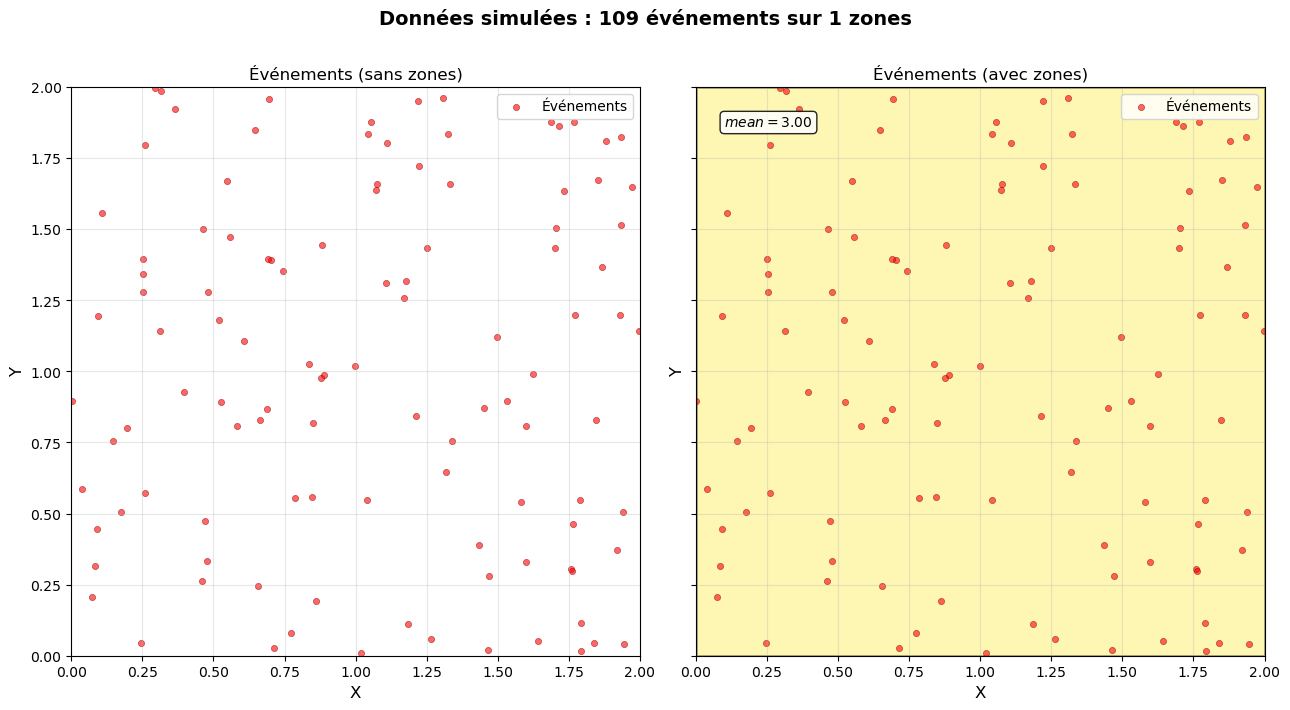

----- JEU DE DONNÉES SIMULÉES -----

Nombre d'événements : 93
Nombre de zones régulières : 3
Intensités : [1.5,3,2.8]
Premiers événements :
    [ v0        v1        v2        ]
0 : [ 0.489837  1.58072   5.36443   ]
1 : [ 0.154978  1.30817   0.545558  ]
2 : [ 0.15369   1.5313    4.30486   ]
3 : [ 0.0844882 1.73307   3.2353    ]
4 : [ 0.406537  1.26443   5.54653   ]
----------------------------- Démarrage Gibbs: 1000 itérations, N=109 -----------------------------

[Gibbs iteration 0] mu_tilde = 3.6354 | |Pi| = 47 | eps = [1.06074735] 
[Gibbs iteration 100] mu_tilde = 3.8333 | |Pi| = 28 | eps = [2.40195854] 
[Gibbs iteration 200] mu_tilde = 3.7625 | |Pi| = 19 | eps = [2.40340146] 
[Gibbs iteration 300] mu_tilde = 3.3108 | |Pi| = 15 | eps = [1.66032462] 
[Gibbs iteration 400] mu_tilde = 3.1928 | |Pi| = 14 | eps = [2.60126711] 
[Gibbs iteration 500] mu_tilde = 3.7352 | |Pi| = 20 | eps = [1.62623015] 
[Gibbs iteration 600] mu_tilde = 3.6309 | |Pi| = 28 | eps = [2.02262755] 
[Gibbs iteratio

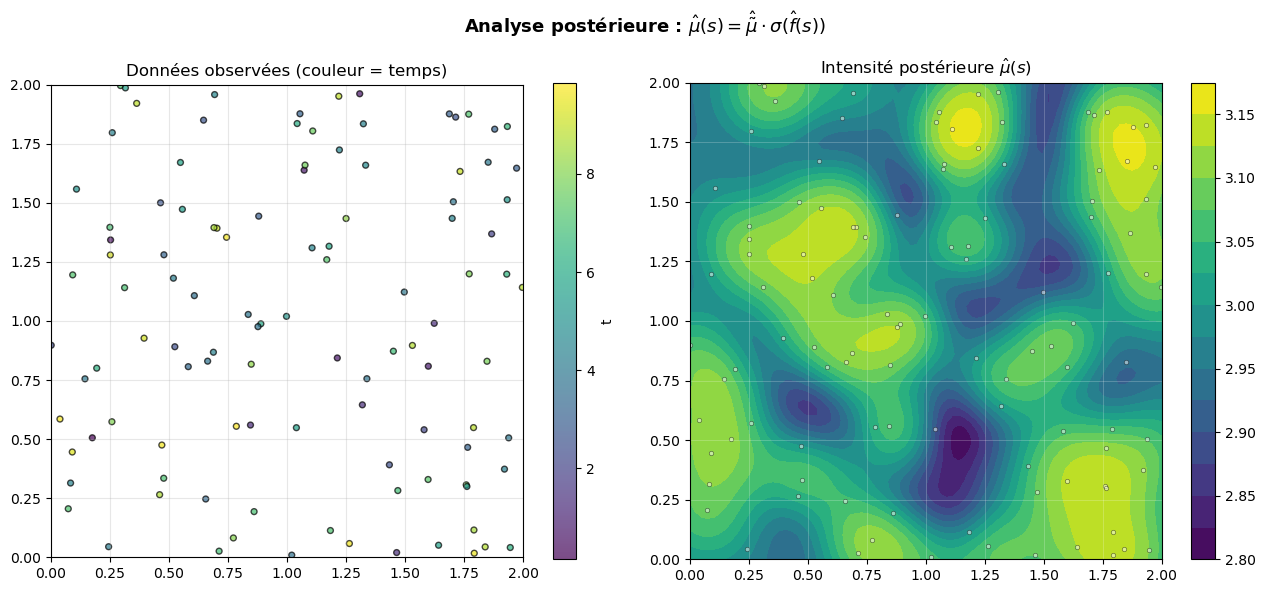

In [20]:
X_bounds=(0.0, 2.0)
Y_bounds=(0.0, 2.0)
T=10.0
nu=[2.5, 0.15, 0.15]
n_iter=1000
burn_in=0.3
seed = 1

# 1) Génération des données
X, zones, Xb, Yb, T_sim, mus_vec = generate_data(
    X_bounds=X_bounds,
    Y_bounds=Y_bounds,
    T=T,
    n_cols=1,
    n_rows=1,
    mus=3.0,
    rng_seed=seed)

plot_poisson_zones_data(
    X=X,
    zones=zones,
    mus_vec=mus_vec,
    X_bounds=Xb,
    Y_bounds=Yb,
    title_prefix="Données simulées",
    show_time_hist=False
)

X2, zones2, Xb2, Yb2, T_sim2, mus_vec2 = generate_data(
    X_bounds=X_bounds,
    Y_bounds=Y_bounds,
    T=T,
    n_cols=3,
    n_rows=1,
    mus=(1.5, 3.0, 2.8),
    rng_seed=seed);

# 2) Areas
Areas = [(poly, 0.0) for poly in zones]

# 3) Gibbs
sampler = SGCP_GibbsSampler(
    X_bounds=Xb,
    Y_bounds=Yb,
    T=T_sim,
    Areas=Areas,
    nu=nu,
    a_mu=1.0,
    b_mu=1.0,
    jitter=1e-5,
    rng_seed=seed
)

N = X.getSize()
x_pt = ot.Point([float(X[i, 0]) for i in range(N)])
y_pt = ot.Point([float(X[i, 1]) for i in range(N)])
t_pt = ot.Point([float(X[i, 2]) for i in range(N)])
eps_init = ot.Point([0.0] * sampler.J)
mu_init = float(max(np.asarray(mus_vec, dtype=float)))

results = sampler.run(
    t=t_pt,
    x=x_pt,
    y=y_pt,
    eps_init=eps_init,
    mu_init=mu_init,
    n_iter=n_iter,
    verbose=True,
    verbose_every=100
)

# 4) Posterior summary
post = sampler.posterior_summary(results, burn_in=burn_in)
print("\n--- Posterior summary ---")
print(f"mutilde_hat = {post['mutilde_hat']}")
print(f"eps_hat     = {np.asarray(post['eps_hat'])}")

# 7) Posterior intensity plot
out = sampler.plot_posterior_intensity(
    x=np.asarray(x_pt, dtype=float),
    y=np.asarray(y_pt, dtype=float),
    t=np.asarray(t_pt, dtype=float),
    results=results,
    nx=80,
    ny=80,
    burn_in=burn_in
)

----- JEU DE DONNÉES SIMULÉES -----

Nombre d'événements : 64
Nombre de zones régulières : 1
Intensités : [3]
Premiers événements :
    [ v0         v1         v2         ]
0 : [ 1.70481    1.30869    2.25008    ]
1 : [ 1.28737    0.546945   2.54572    ]
2 : [ 1.77966    1.48019    3.92988    ]
3 : [ 0.00288049 1.12257    1.57722    ]
4 : [ 0.960574   0.421782   0.18465    ]
----- JEU DE DONNÉES SIMULÉES -----

Nombre d'événements : 37
Nombre de zones régulières : 3
Intensités : [0.5,3,2.8]
Premiers événements :
    [ v0       v1       v2       ]
0 : [ 0.62059  1.09471  3.21842  ]
1 : [ 0.124006 1.70481  4.44916  ]
2 : [ 0.715678 1.42281  4.71928  ]
3 : [ 1.10406  0.564391 0.214359 ]
4 : [ 1.0611   0.344785 1.38308  ]


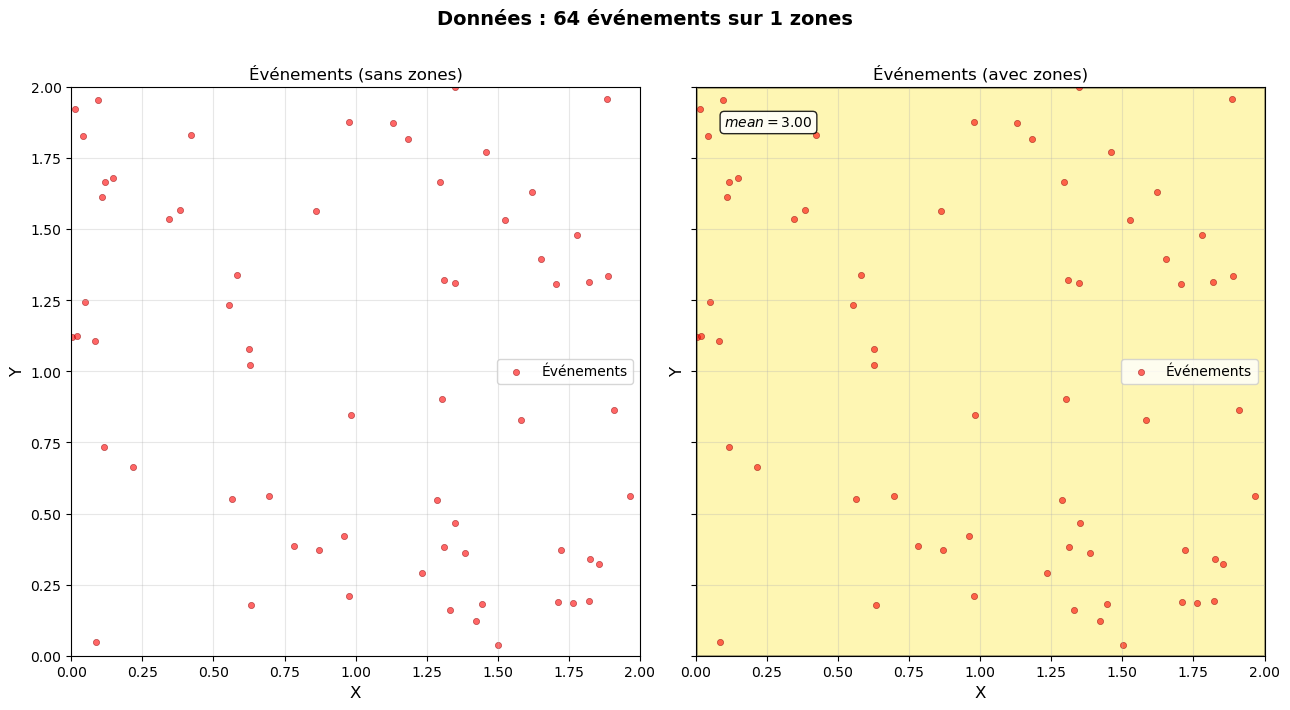

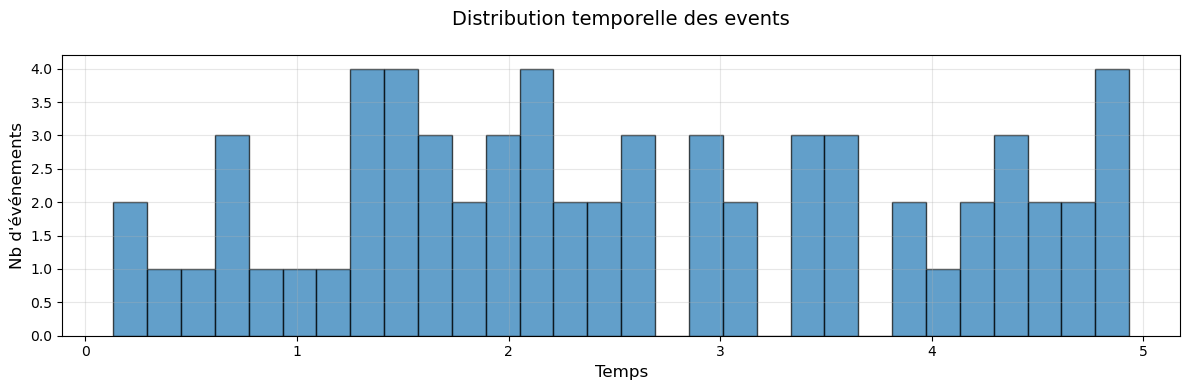


[1/12] Test nu = (1.0, 0.05, 0.05)


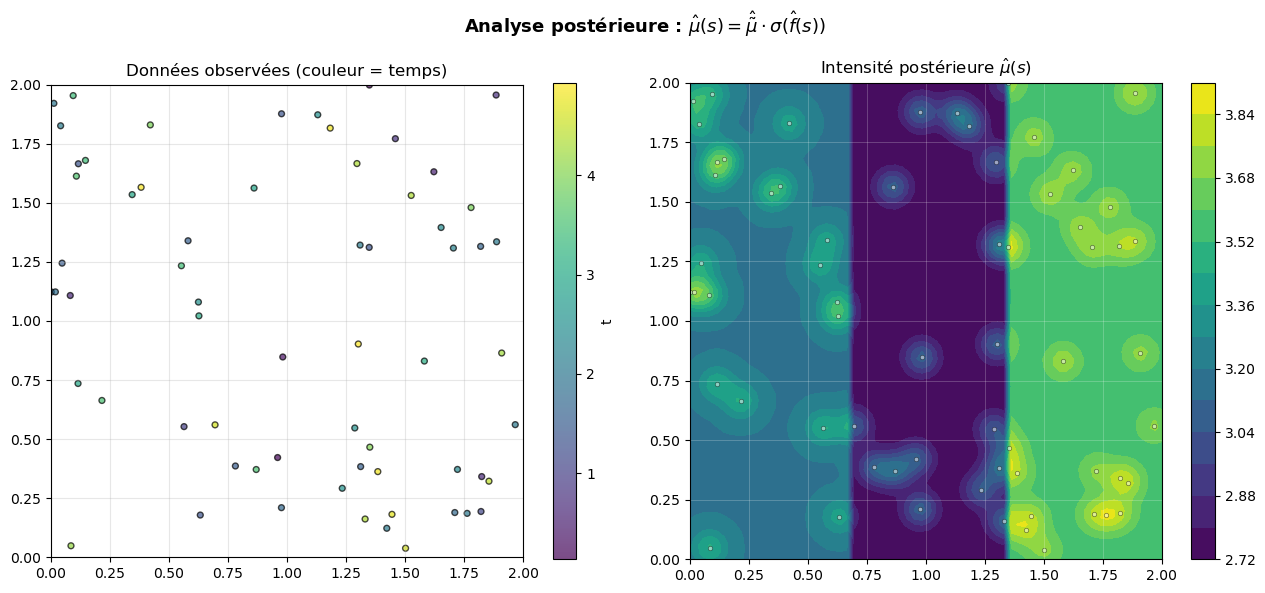


[2/12] Test nu = (2.0, 0.05, 0.05)


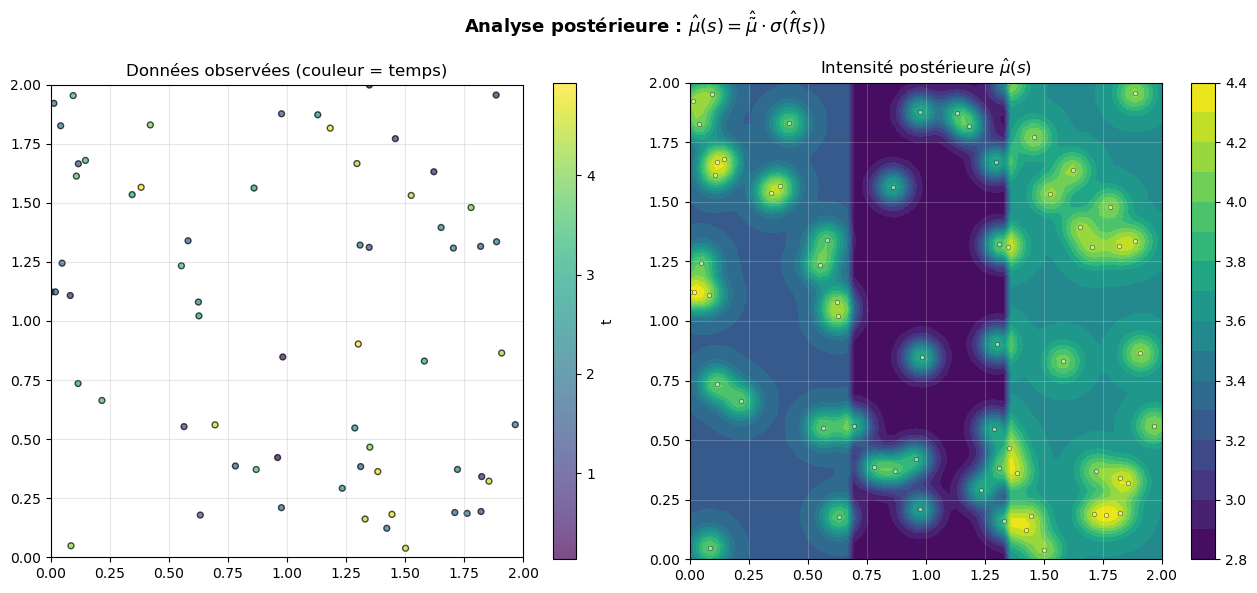


[3/12] Test nu = (3.0, 0.05, 0.05)


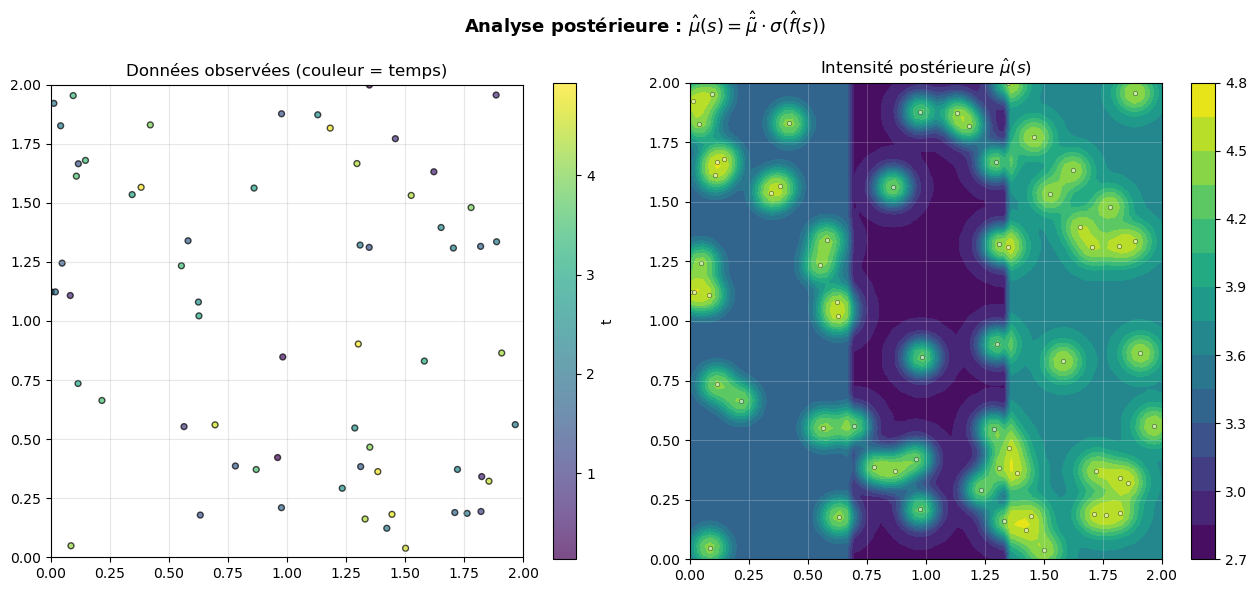


[4/12] Test nu = (1.0, 0.1, 0.1)


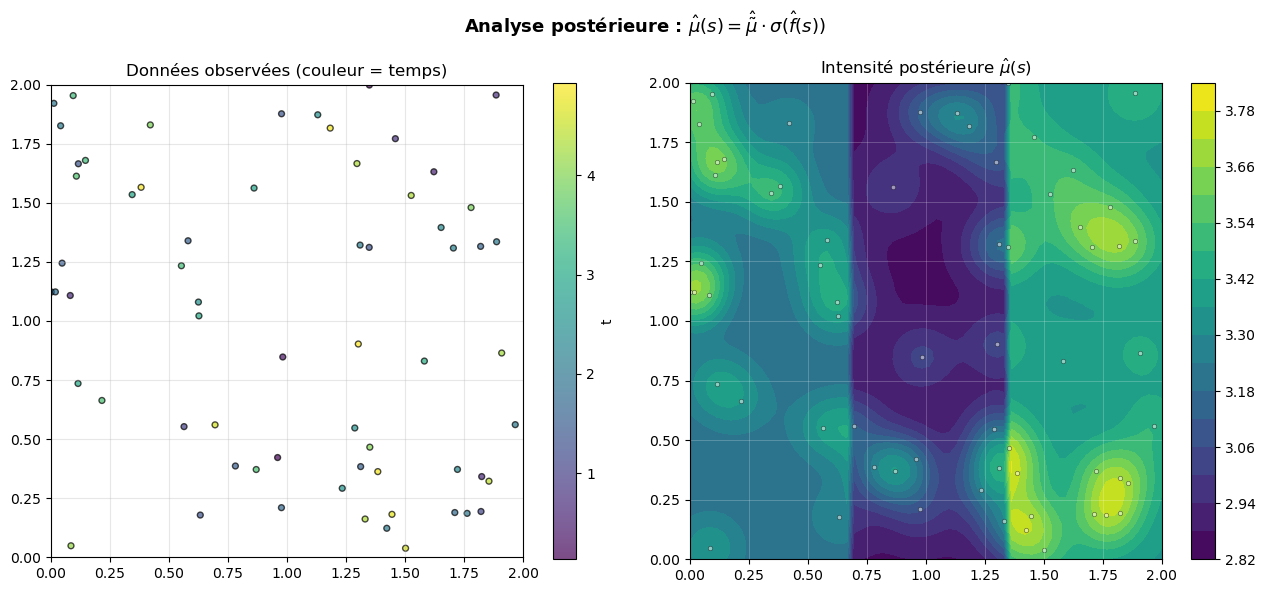


[5/12] Test nu = (2.0, 0.1, 0.1)


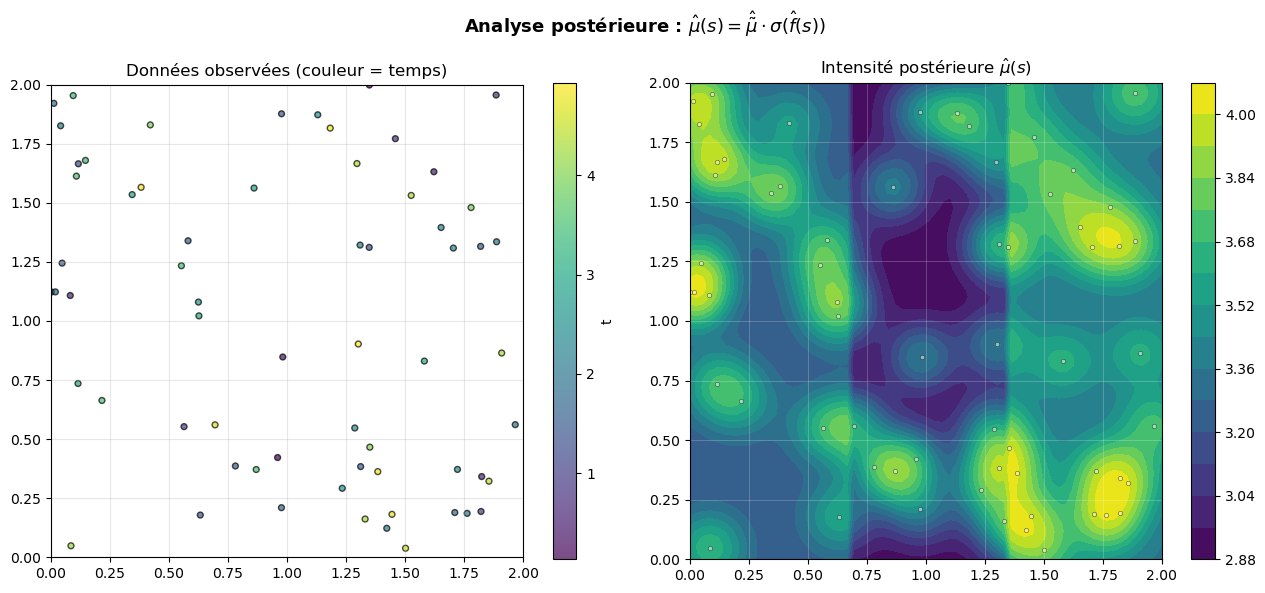


[6/12] Test nu = (3.0, 0.1, 0.1)


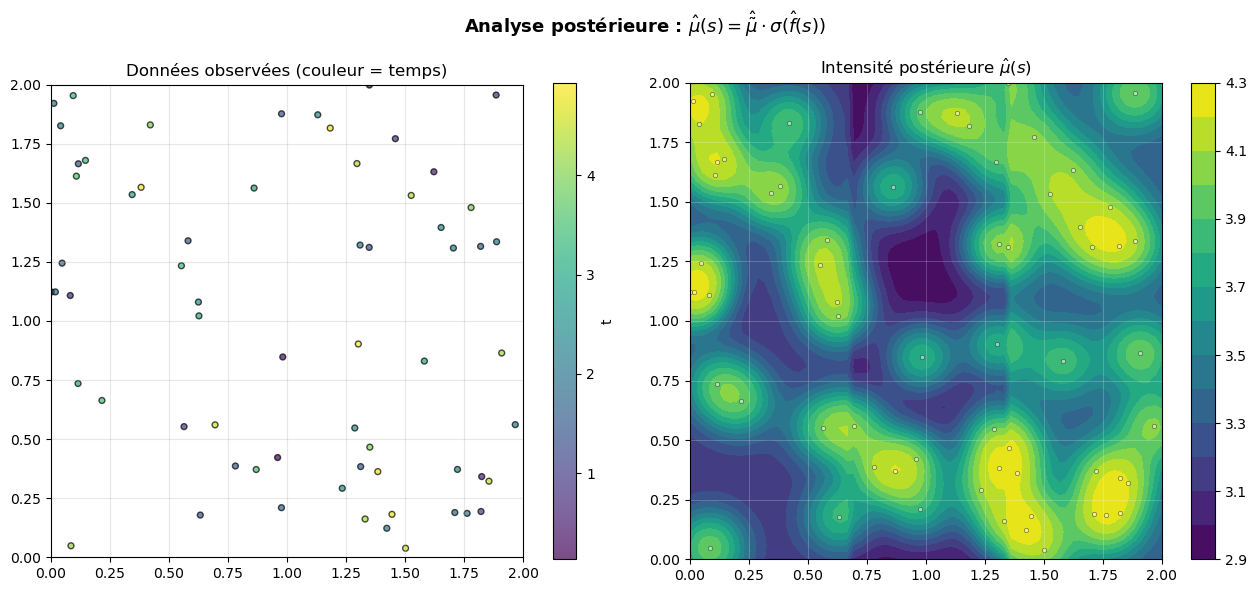


[7/12] Test nu = (1.0, 0.15, 0.15)


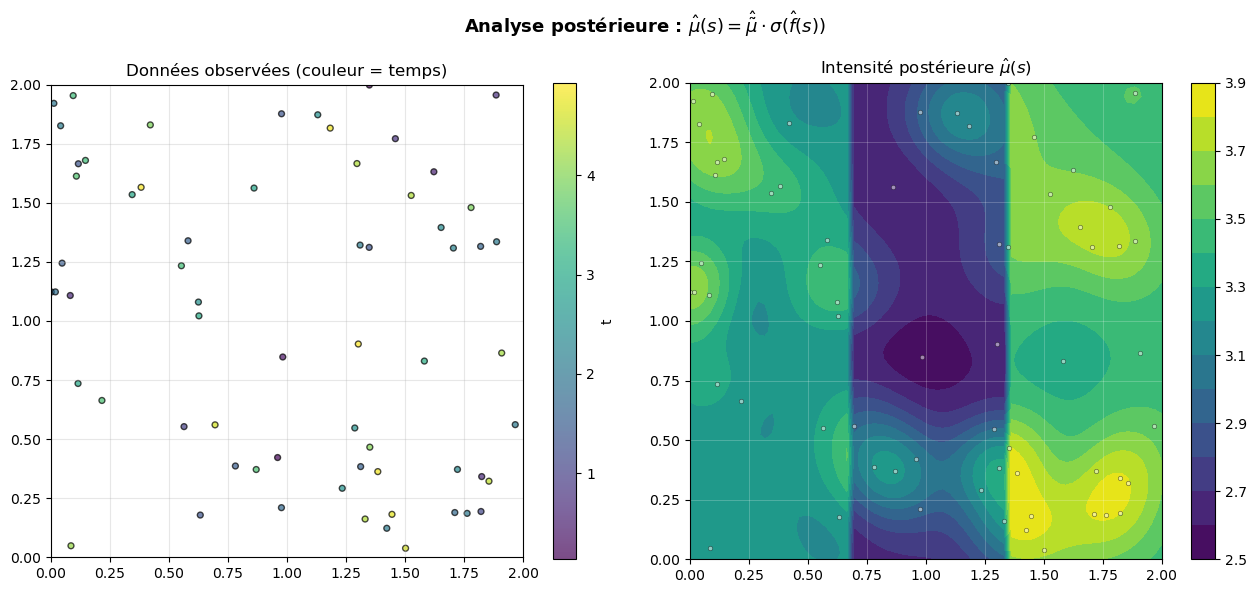


[8/12] Test nu = (2.0, 0.15, 0.15)


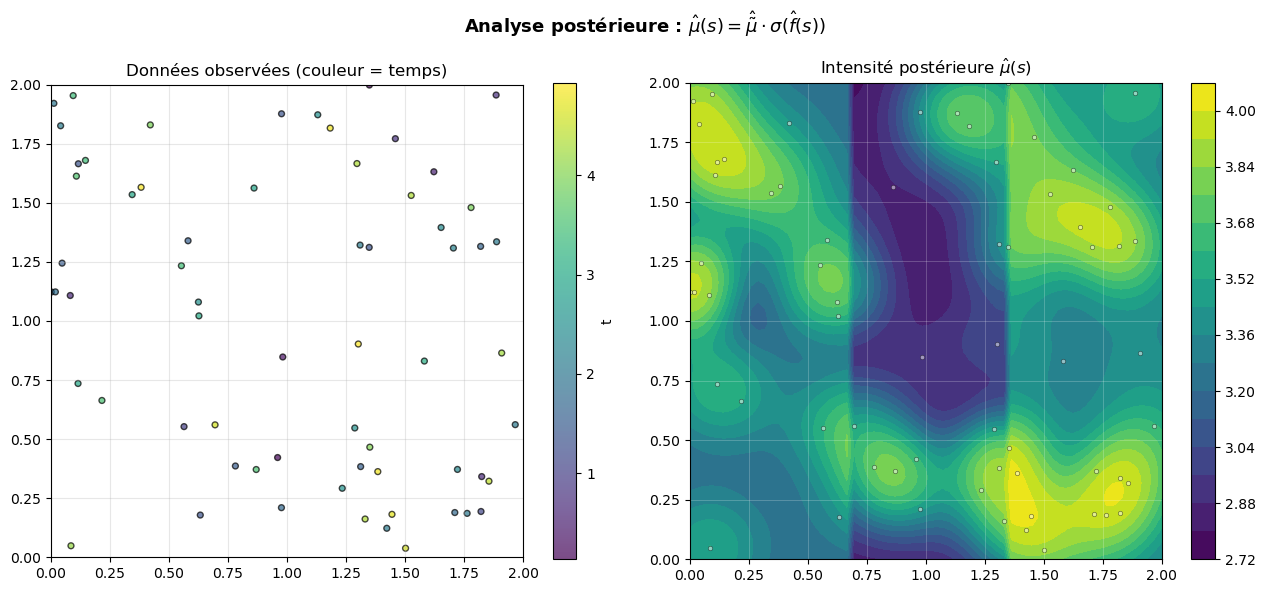


[9/12] Test nu = (3.5, 0.15, 0.15)


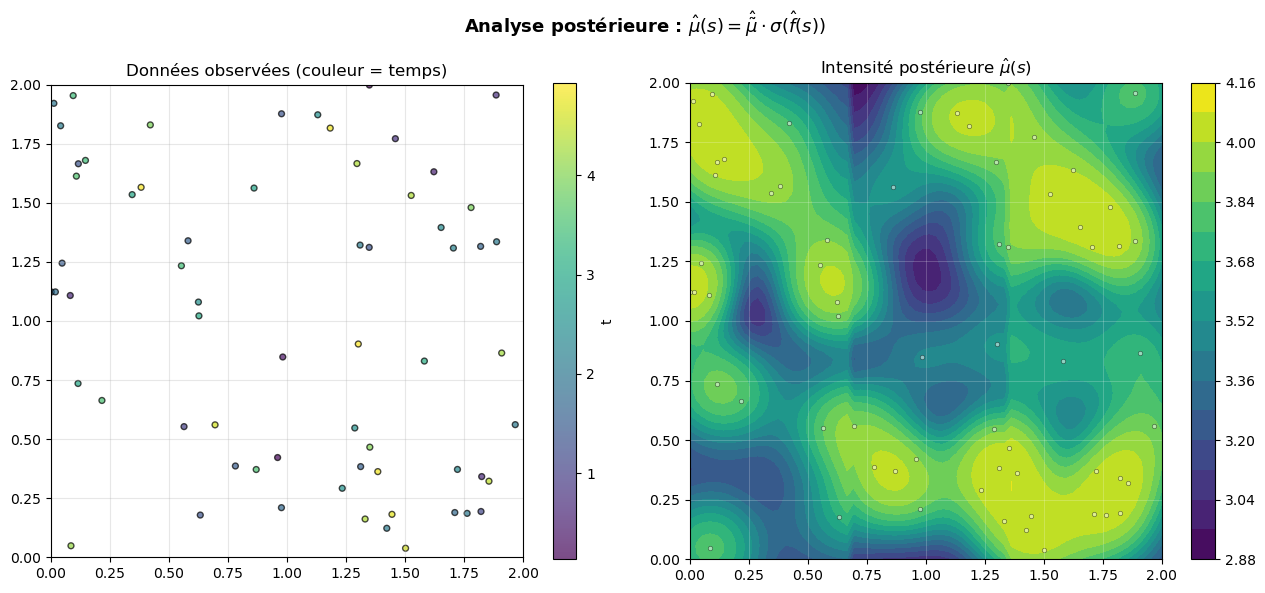


[10/12] Test nu = (1.0, 0.25, 0.25)


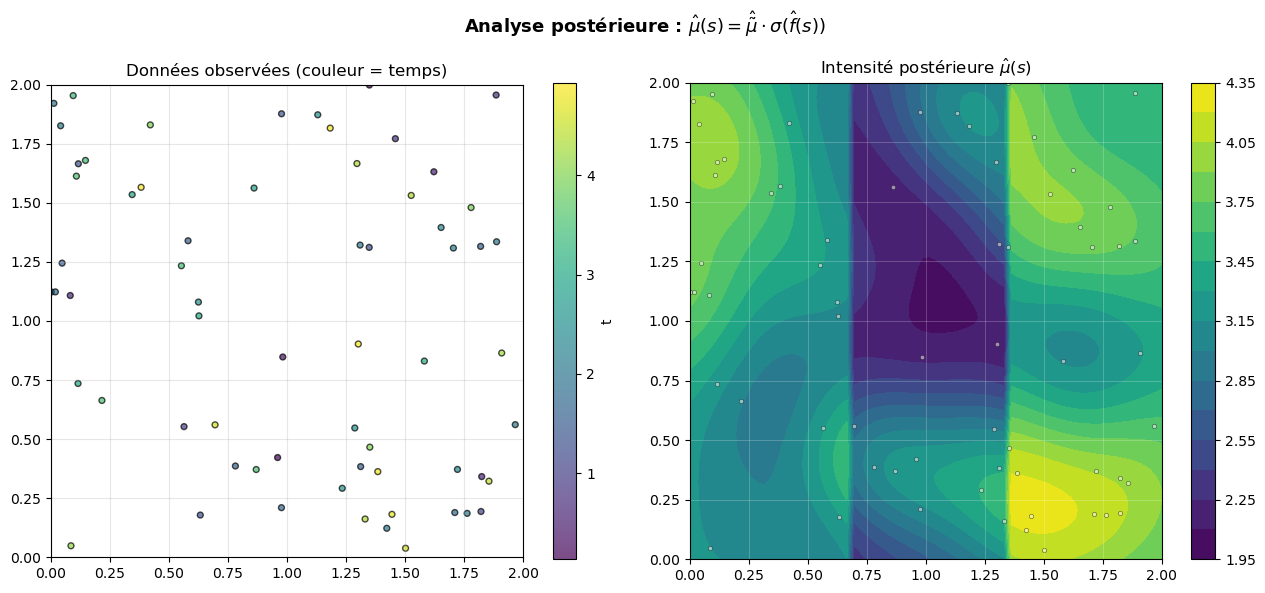


[11/12] Test nu = (2.0, 0.25, 0.25)


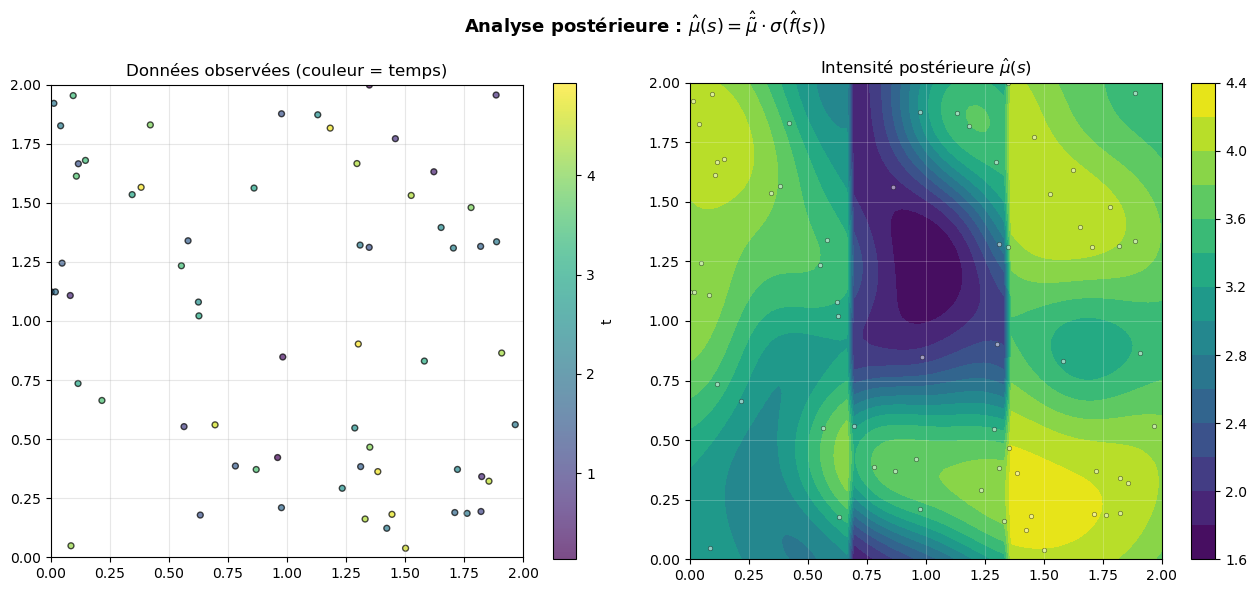


[12/12] Test nu = (3.0, 0.25, 0.25)


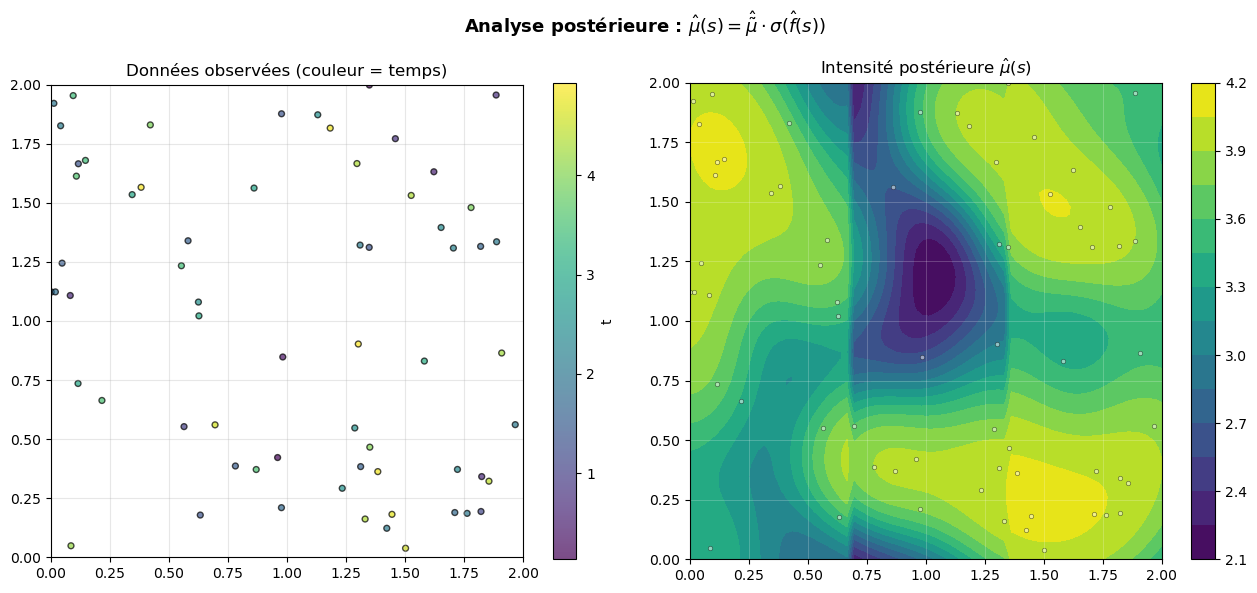

In [10]:
def test_impact_nu(
    X,
    zones,
    Xb,
    Yb,
    T_sim,
    mus_vec,
    nu_list,
    n_iter=1000,
    burn_in=0.3,
    verbose=False,
    verbose_every=100,
    nx_plot=70,
    ny_plot=70,
):
    """
    
    """
    N = X.getSize()
    x_pt = ot.Point([float(X[i, 0]) for i in range(N)])
    y_pt = ot.Point([float(X[i, 1]) for i in range(N)])
    t_pt = ot.Point([float(X[i, 2]) for i in range(N)])

    Areas = [(poly, 0.0) for poly in zones]

    for k, nu in enumerate(nu_list):
        print("\n" + "=" * 90)
        print(f"[{k+1}/{len(nu_list)}] Test nu = {nu}")
        print("=" * 90)

        sampler = SGCP_GibbsSampler(
            X_bounds=Xb,
            Y_bounds=Yb,
            T=T_sim,
            Areas=Areas,
            nu=nu,
            a_mu=1.0,
            b_mu=1.0,
            jitter=1e-5,
            rng_seed=(0 + k),
        )

        eps_init = ot.Point([0.0] * sampler.J)
        mu_init = float(max(np.asarray(mus_vec)))

        results = sampler.run(
            t=t_pt,
            x=x_pt,
            y=y_pt,
            eps_init=eps_init,
            mu_init=mu_init,
            n_iter=n_iter,
            verbose=verbose,
            verbose_every=verbose_every,
        )

        sampler.plot_posterior_intensity(
            x=np.asarray(x_pt),
            y=np.asarray(y_pt),
            t=np.asarray(t_pt),
            results=results,
            nx=nx_plot,
            ny=ny_plot,
            burn_in=burn_in,
        )



X_bounds = (0.0, 2.0)
Y_bounds = (0.0, 2.0)
T = 5.0

X, zones, Xb, Yb, T_sim, mus_vec = generate_data(
    X_bounds=X_bounds,
    Y_bounds=Y_bounds,
    T=T,
    n_cols=1,
    n_rows=1,
    mus=3,
    rng_seed=3,
)

X2, zones2, Xb2, Yb2, T_sim2, mus_vec2 = generate_data(
    X_bounds=X_bounds,
    Y_bounds=Y_bounds,
    T=T,
    n_rows=1,
    n_cols=3,
    mus=(0.5, 3.0, 2.8),
    rng_seed=3,
)

plot_poisson_zones_data(
    X=X,
    zones=zones,
    mus_vec=mus_vec,
    X_bounds=Xb,
    Y_bounds=Yb,
    title_prefix="Données",
    show_time_hist=True,
)

nu_list = [
    (1.0, 0.05, 0.05),
    (2.0, 0.05, 0.05),
    (3.0, 0.05, 0.05),
    (1.0, 0.10, 0.10),
    (2.0, 0.10, 0.10),
    (3.0, 0.10, 0.10),
    (1.0, 0.15, 0.15),
    (2.0, 0.15, 0.15),
    (3.5, 0.15, 0.15),
    (1.0, 0.25, 0.25),
    (2.0, 0.25, 0.25),
    (3.0, 0.25, 0.25),
]

test_impact_nu(
    X=X,
    zones=zones2,
    Xb=Xb,
    Yb=Yb,
    T_sim=T_sim,
    mus_vec=mus_vec,
    nu_list=nu_list,
    n_iter=3000,
    burn_in=0.3,
    verbose=False,
    verbose_every=100,
    nx_plot=70,
    ny_plot=70,
)


----- JEU DE DONNÉES SIMULÉES -----

Nombre d'événements : 247
Nombre de zones régulières : 1
Intensités : [3]
Premiers événements :
    [ v0          v1          v2          ]
0 : [  1.70481     1.80783     4.91357    ]
1 : [  1.28737     1.14137    16.2941     ]
2 : [  1.77966     0.372961    0.511162   ]
3 : [  0.00288049  0.0506416  12.7492     ]
4 : [  0.960574    0.147798    6.15776    ]
----- JEU DE DONNÉES SIMULÉES -----

Nombre d'événements : 159
Nombre de zones régulières : 3
Intensités : [0.5,3,2.8]
Premiers événements :
    [ v0           v1           v2           ]
0 : [  0.568272     0.116951     8.60829     ]
1 : [  0.429123     0.382679     9.76794     ]
2 : [  0.593221     0.625313    18.5536      ]
3 : [  0.000960162  0.115635    13.5099      ]
4 : [  0.320191     0.0950814   18.2465      ]


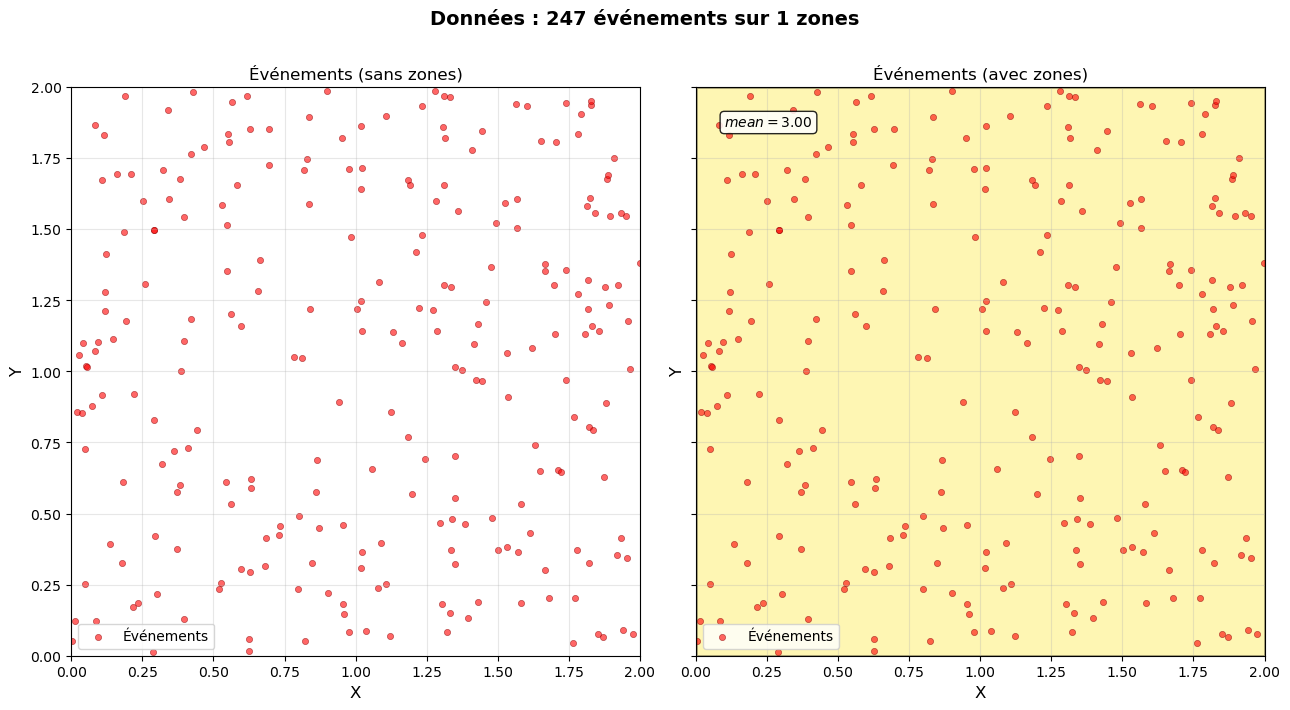

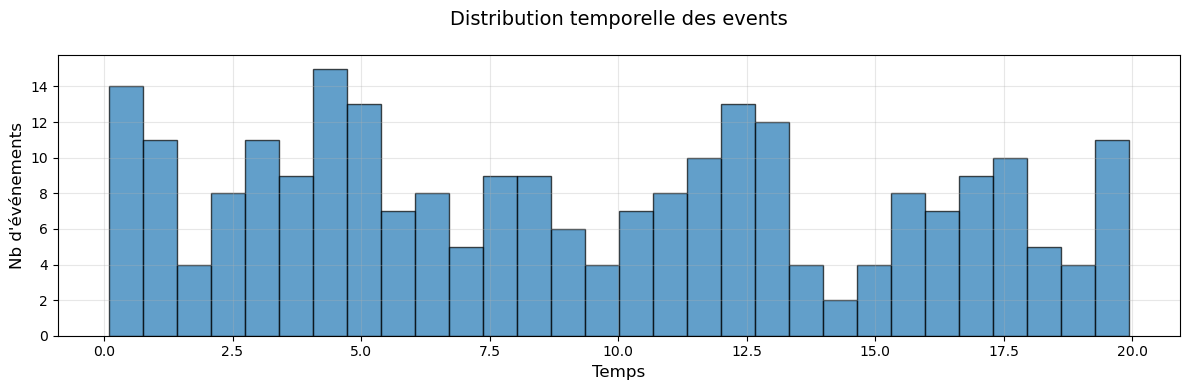


[1/5] Test nu = (1.0, 0.1, 0.1)


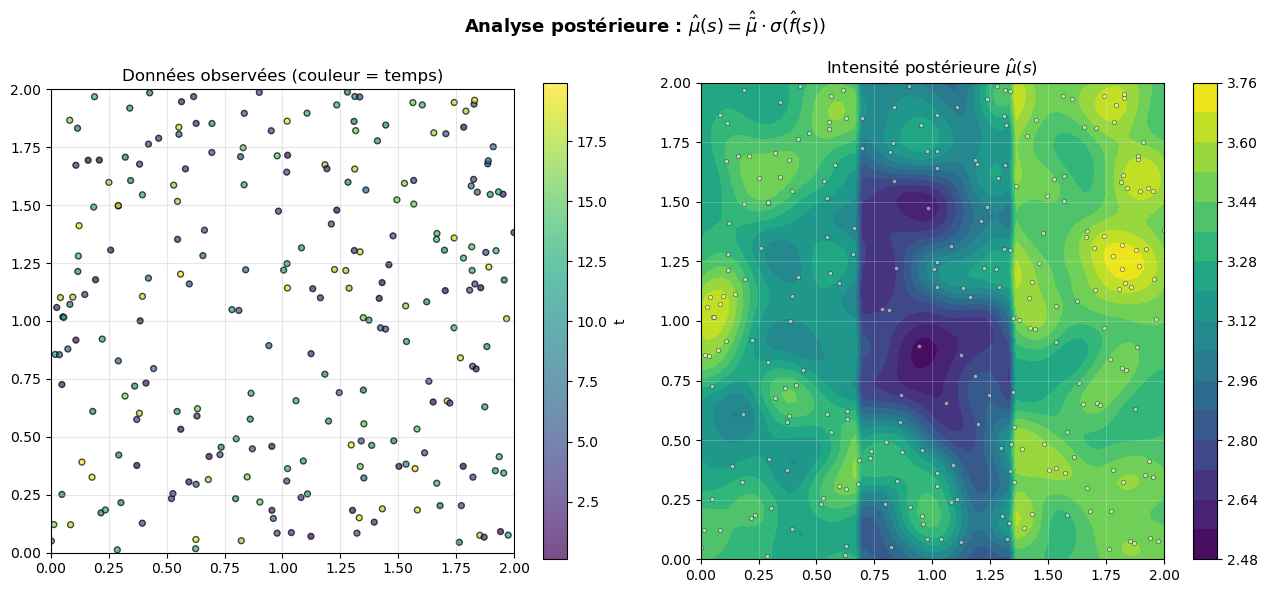


[2/5] Test nu = (2.0, 0.1, 0.1)


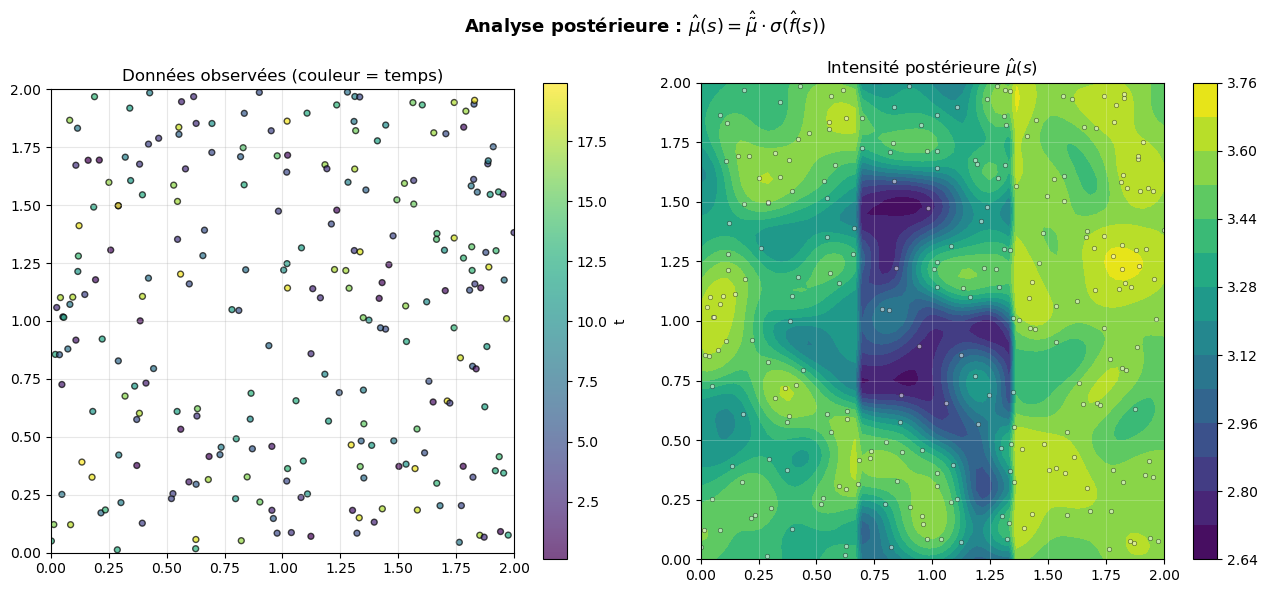


[3/5] Test nu = (3.5, 0.1, 0.1)


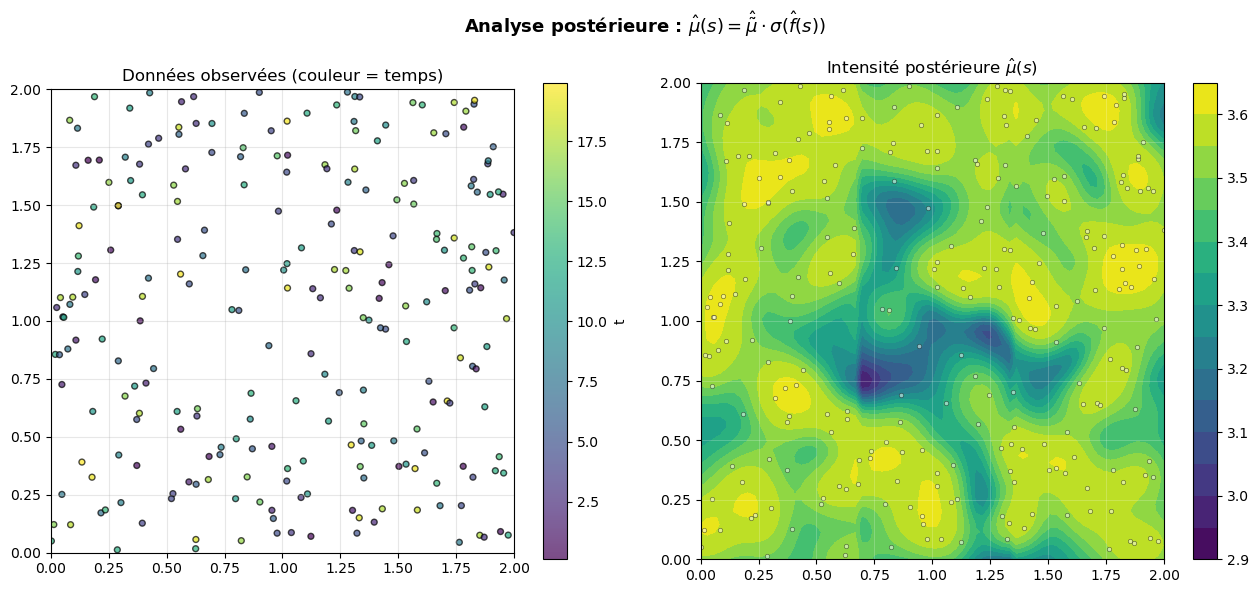


[4/5] Test nu = (2.0, 0.15, 0.15)


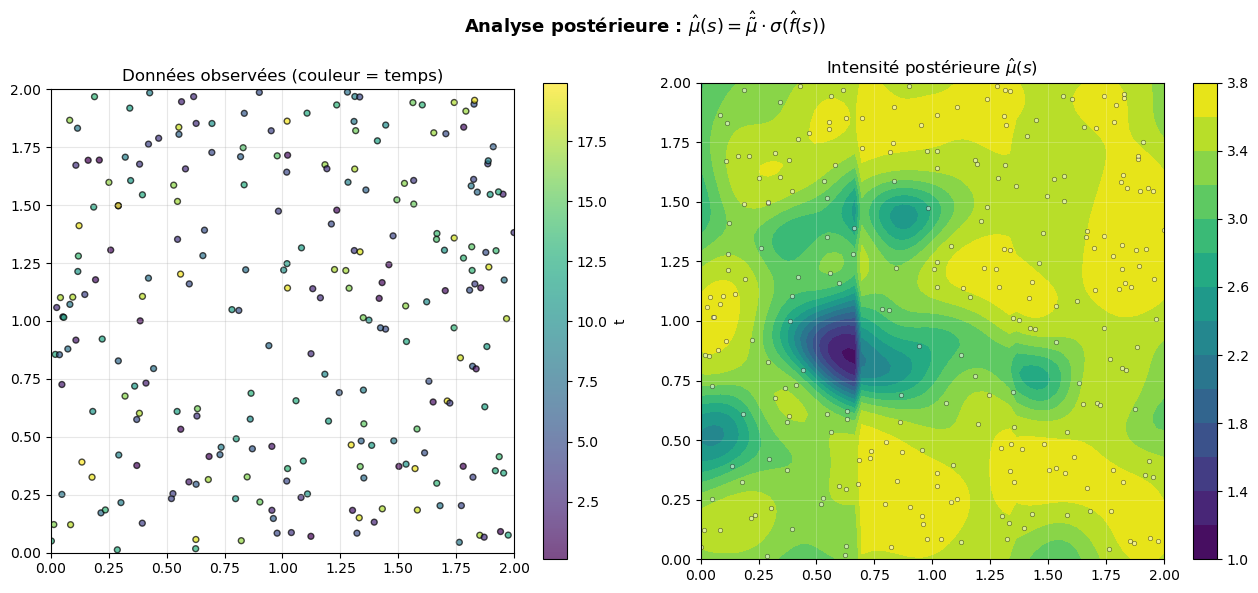


[5/5] Test nu = (3.5, 0.15, 0.15)


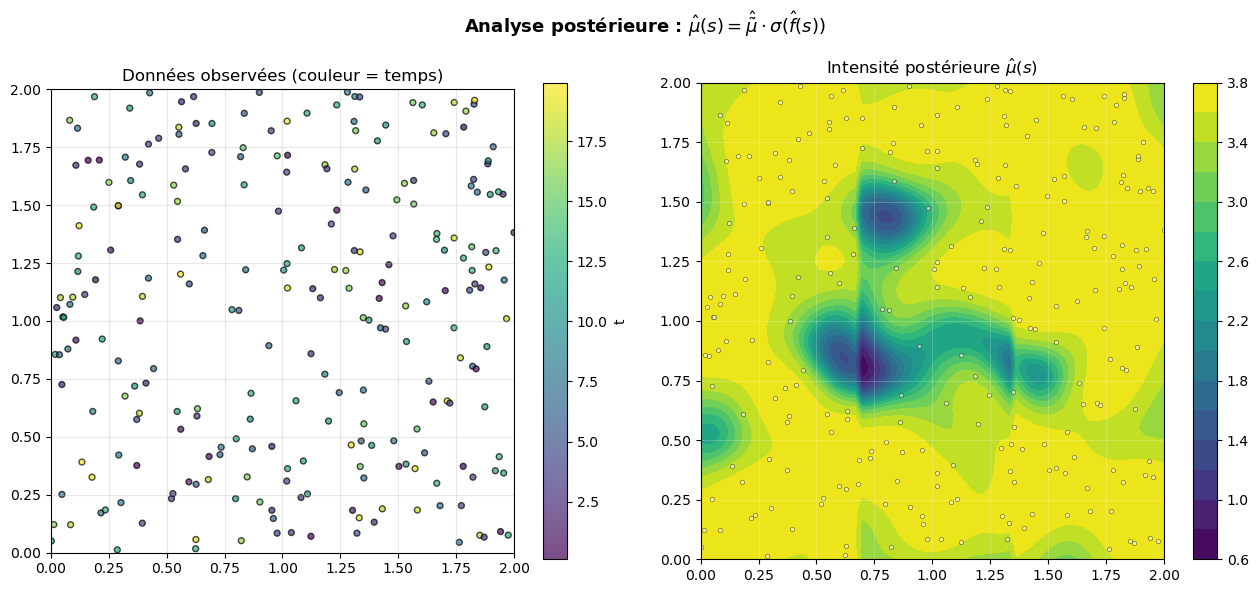

In [12]:
def test_impact_nu(
    X,
    zones,
    Xb,
    Yb,
    T_sim,
    mus_vec,
    nu_list,
    n_iter=1000,
    burn_in=0.3,
    verbose=False,
    verbose_every=100,
    nx_plot=70,
    ny_plot=70,
):
    """
    
    """
    N = X.getSize()
    x_pt = ot.Point([float(X[i, 0]) for i in range(N)])
    y_pt = ot.Point([float(X[i, 1]) for i in range(N)])
    t_pt = ot.Point([float(X[i, 2]) for i in range(N)])

    Areas = [(poly, 0.0) for poly in zones]

    for k, nu in enumerate(nu_list):
        print("\n" + "=" * 90)
        print(f"[{k+1}/{len(nu_list)}] Test nu = {nu}")
        print("=" * 90)

        sampler = SGCP_GibbsSampler(
            X_bounds=Xb,
            Y_bounds=Yb,
            T=T_sim,
            Areas=Areas,
            nu=nu,
            a_mu=1.0,
            b_mu=1.0,
            jitter=1e-5,
            rng_seed=(0 + k),
        )

        eps_init = ot.Point([0.0] * sampler.J)
        mu_init = float(max(np.asarray(mus_vec)))

        results = sampler.run(
            t=t_pt,
            x=x_pt,
            y=y_pt,
            eps_init=eps_init,
            mu_init=mu_init,
            n_iter=n_iter,
            verbose=verbose,
            verbose_every=verbose_every,
        )

        sampler.plot_posterior_intensity(
            x=np.asarray(x_pt),
            y=np.asarray(y_pt),
            t=np.asarray(t_pt),
            results=results,
            nx=nx_plot,
            ny=ny_plot,
            burn_in=burn_in,
        )



X_bounds = (0.0, 2.0)
Y_bounds = (0.0, 2.0)
T = 20.0

X, zones, Xb, Yb, T_sim, mus_vec = generate_data(
    X_bounds=X_bounds,
    Y_bounds=Y_bounds,
    T=T,
    n_cols=1,
    n_rows=1,
    mus=3,
    rng_seed=3,
)

X2, zones2, Xb2, Yb2, T_sim2, mus_vec2 = generate_data(
    X_bounds=X_bounds,
    Y_bounds=Y_bounds,
    T=T,
    n_rows=1,
    n_cols=3,
    mus=(0.5, 3.0, 2.8),
    rng_seed=3,
)

plot_poisson_zones_data(
    X=X,
    zones=zones,
    mus_vec=mus_vec,
    X_bounds=Xb,
    Y_bounds=Yb,
    title_prefix="Données",
    show_time_hist=True,
)

nu_list = [
    (1.0, 0.10, 0.10),
    (2.0, 0.10, 0.10),
    (3.5, 0.10, 0.10),
    (2.0, 0.15, 0.15),
    (3.5, 0.15, 0.15),
]

test_impact_nu(
    X=X,
    zones=zones2,
    Xb=Xb,
    Yb=Yb,
    T_sim=T_sim,
    mus_vec=mus_vec,
    nu_list=nu_list,
    n_iter=1000,
    burn_in=0.3,
    verbose=False,
    verbose_every=100,
    nx_plot=70,
    ny_plot=70,
)